# Non-Isothermal Packed Bed Reactor

Prepared by: Fathya Salih (fsalih@nd.edu) and Connor Schmidt (cschmid9@nd.edu)

Revised by: Vivian Okorie (vokorie3@nd.edu)


## 1. Problem Description

Chemical Engineering undergraduates often have a strong foundation in reaction engineering but may not have explored non-ideal reactors. This problem aims to provide practice in designing reactors under non-isothermal conditions, where kinetics are influenced by equilibrium. The central question to be addressed is, "How can we effectively control the reaction temperature when a cooling jacket is not a viable option?"

## 1.1 Learning Objectives

1. Develop the ability to diagram and label complex chemical engineering problems.
2. Derive mass and energy balance equations in the given formats.
3. Gain proficiency in solving ordinary differential equations (ODEs) using `scipy.integrate.solve_ivp()`.
4. Improve skills in creating plots for multiple series using for-loops.
5. Explore the impact of thermal non-idealities on reactor performance.

Additional Resources

1. "Elements of Chemical Reaction Engineering, Fifth Edition" by H. Scott Fogler
2. [Class website](https://ndcbe.github.io/data-and-computing/intro.html), with a specific focus on the notebook related to [reaction rates](https://ndcbe.github.io/data-and-computing/notebooks/07/Example-Reaction-Rates.html)

## 1.2 Problem Statement

Adapted from "Problem 11-7, Elements of Chemical Reaction Engineering, Fifth Edition" by H. Scott Fogler

In a packed-bed reactor operating under high pressure (150 bar at the inlet), a gas-phase reversible reaction takes place:

\begin{equation}
A \rightarrow B
\end{equation}

The feed into the reactor consists of inert species $I$ and reactant species $A$," in a 2:1 molar ratio. The initial molar flow rate of A is 5 mol/min, and it enters the reactor at 300 K with a concentration of 2 mol/L. In this problem, we will work with volume-based parameters ($V \rho_B=W$, and $r_i$ is expressed in terms of volume per time per reactor volume), where:

- $V \rho_B$ is the volume of the reactor, and
- $r_i [\frac{mol\  'i'\  produced}{time . vol_{reactor}}] = r_i' [\frac{mol\  'i'\  produced}{min . kg_{cat}}]*\rho [\frac{kg_{cat}}{vol_{reactor}}]$.




___Additional Information___                                            
|___Inlet Conditions___             | ___Kinetic Parameters___           |
|:-:                                |:-:                                 |
|$F_{A0}=$ 5.0 [mol/min]            |  $k_1=$ 0.1 [min^{-1}] at 300 K    |
|$C_{A0}=$ 2 [mol/dm^3]             | $K_C =$ 1000 [-] at 300 K          |
|$C_{I0}= Θ_I C_{A0}$; $Θ_I = 2$    | $E =$ 10,000 [cal/mol]             |
|$T_{0}=$ 300 [K]                   | ___Energy Equation Parameters___   |
|___Reactor Properties___           | $ΔH_{Rxn}=$ -20,000 [cal/mol of A] |
|$V=$ 40 [dm^3]                     | $C_{p,I} =$ 18 [cal/mol.K]         |
|$α ρ_B=$ 0.02 [dm^{-3}]            | $C_{p,A} =$ 160 [cal/mol.K]        |
|$ρ_B=$ 1.2 [kg/dm^3]               | $C_{p,B} =$ 160 [cal/mol.K]        |


Considering adiabatic operation,

1. Derive the mole and energy balance equations for a PBR.

2. Solve the system of ODEs (assembled using the provided hints) numerically for the given parameters and plot profiles that illustrate the variations in reactor volume for conversion ( 𝑋 ), equilibrium conversion ( 𝑋𝑒 ), temperature ( 𝑇 ), pressure ( 𝑝 ), and the rate of reaction ( −𝑟𝐴 ).

3. Analyze the effect of heat capacities and pressure drop using parametric sweeps.

4. Analyze the effect of inlet temperature ($T_0$) and the inlet fraction of inerts ($\Theta_I$) using parametric sweeps. Then, find the optimal combination of $T_0$ and $\Theta_I$ that controls the reaction temprature to maximize conversion.

## 1.3 Import Libraries

In [1]:
# Importing libraries
import numpy as np
import scipy as sp
from scipy import integrate
import scipy.integrate as sp
import matplotlib.pyplot as plt

## 1.4 Hints



### A) Algorithm

*Fogler* provides algorithms or a sequence of assembling equations needed to design different kinds of reactors. The equations below are the algorithm for designing a non-isothermal non-isobaric reactor.

__1. Mole Balance__

The design equation (mole balance equation) of a gas reaction in a PBR is most conveniently written in terms of molar flow rates and catalyst weight, so that for component ‘$i$’,

\begin{equation}
\frac{dF_i}{dW} = r'_i
\end{equation}

Where $r'_i$ is the rate of production of component ‘$i$’ per unit of catalyst mass.

__2. Rate Law__

Only one reaction occurs in this system, and it can be written in terms of component '$A$', since it is the only reactant (and hence the limiting reactant).

The rate of *production* of '$A$' is:
\begin{equation}
r'_A = - k_1 \left[ C_A - \frac{C_B}{K_c} \right]
\end{equation}

Where:

\begin{equation}
k_1(T) = k_1(T_1) exp \left[ \frac{E}{R} \left( \frac{1}{T_1} - \frac{1}{T} \right) \right]
\end{equation}

\begin{equation}
K_c(T) = K_c(T_2) exp \left[ \frac{ΔH_{rxn}}{R} \left( \frac{1}{T_2} - \frac{1}{T} \right) \right]
\end{equation}

__3. Stoichiometry__

From the reaction stoichiometry, the rate of production of component 'B' is:
\begin{equation}
\frac{r'_B}{v_B} = \frac{r'_A}{v_A}
\end{equation}

Where the stoichiometric coefficients are $v_A=-1$ and $v_B=1$, leaving

\begin{equation}
r'_B = - r'_A
\end{equation}

And for the inert,
\begin{equation}
r'_I = 0
\end{equation}

Also, reaction rates ($r'_i$) need to be expressed in terms of molar flowrates to match the mole balance equation.

Thus, applying the ideal gas law, concentrations can be written as:
\begin{equation}
C_A  = C_{T0} \frac{F_A}{F_{T0}} \frac{T_0}{T} \frac{P}{P_0}
\end{equation}

\begin{equation}
C_B  = C_{T0} \frac{F_B}{F_{T0}} \frac{T_0}{T} \frac{P}{P_0}
\end{equation}

\begin{equation}
C_I  = C_{T0} \frac{F_I}{F_{T0}} \frac{T_0}{T} \frac{P}{P_0}
\end{equation}

Where $C_{T0}$ is the total molar concentration at the inlet, meaning:
\begin{equation}
C_{T0} = \frac{P_0}{R T_0}
\end{equation}

__4. Energy Balance__

For an adiabatic PBR (no heat added or removed),

\begin{equation}
\frac{dT}{dW} = \frac{r'_A ΔH_{rxn}}{\sum\limits_i F_i C_{p,i}}
\end{equation}

Where:
$\Delta H_{rxn} \equiv$ the heat released by the reaction per mole of '$A$' reacted/consumed, and is a function of temperature

__5. Pressure Drop Equation__

The pressure drop through a packed bed can be described using the following form of the Ergun equation

\begin{equation}
\frac{dp}{dW} = -\frac{α}{2p} \frac{F_T}{F_{T0}} \frac{T}{T_0}
\end{equation}

Where:

$p \equiv$ The pressure ratio ($P/P_0$) [dimensionless]

$\alpha \equiv$ pressure ratio drop per unit mass of catalyst mass [$kg_{cat}^{-1}$]

$\alpha$ lumps a number of packed bed parameters and important material properties like void fraction, particle size, gas viscosity ,etc. It is used here to simplify using the Ergun equation.

### B) Additional Equations and Parameters

**1. Equilibrium Conversion**

Eqilibrium conversion is calculated at equilibrium, where the net rate of reaction is zero. Setting $r'_A=0$ in the equation provided above yeilds:

\begin{equation}
X_e = \frac{K_c}{1+K_c}
\end{equation}

**2. Temperature Dependence**

The temperature dependence of the heat of reaction can be written using a known value for $\Delta H_{rxn}$ at a reference temperature $T_R$

\begin{equation}
\Delta H_{rxn}(T) = \Delta H_{rxn}(T_R) + \Delta C_p (T-T_R)
\end{equation}

Where $\Delta C_p$ lumps the temperature dependence
\begin{equation}
\Delta C_p = \sum\limits_i v_i C_{p,i}
\end{equation}

## 1.5 Derivation of Mole and Energy Balances

### 1a. Sketch & Control Volume

Draw a sketch of a PBR and on the sketch, select an appropriate control volume and indicate the selected volume on the sketch

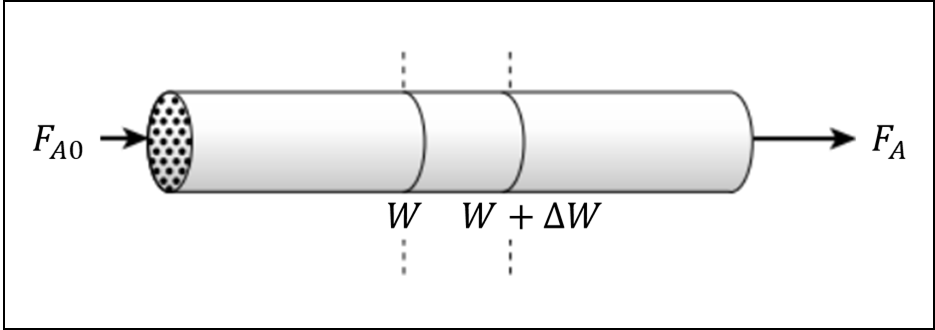

### 1b. Mole Balance

Apply a mole balance on component ‘$i$’ in the selected control volume and attempt to produce the mole balance equation provided in the hints


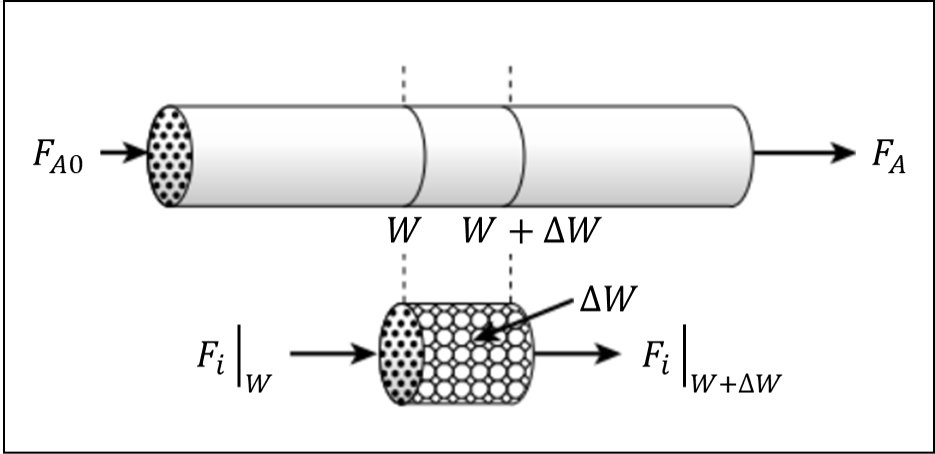


The mole balance for each component on the selected control volume can be written as:

\begin{equation}
F_{i_{in}} - F_{i_{out}} + F_{i_{gen}} = F_{i_{accumulation}}
\end{equation}

But,
- $F_{i_{accumulation}}$ is 0 at steady state
- Generation is $r'_i\Delta W$

So we can rewrite as:
\begin{equation}
F_{i_{in}} - F_{i_{out}} + r'_i\Delta W = 0
\end{equation}

Where $r'_i$ is rate of production of component ‘i’ per unit of catalyst mass, $F_{i_{in}}$ and $F_{i_{out}}$ are the molar flow rates in and out of the reactor for component 'i'.

Solving for $r'_i$ we find

\begin{equation}
r'_i = \frac{-(F_{i_{in}} - F_{i_{out}})}{\Delta W}
\end{equation}

With infinitely small $\Delta W$ we arrive at the mole balance equation provided in the hints:
\begin{equation}
r'_i = \frac{dF_i }{ dW }
\end{equation}

### 1c. Energy Balance

Apply an energy balance on the selected control volume and attempt to produce the energy balance equation provided in the hints

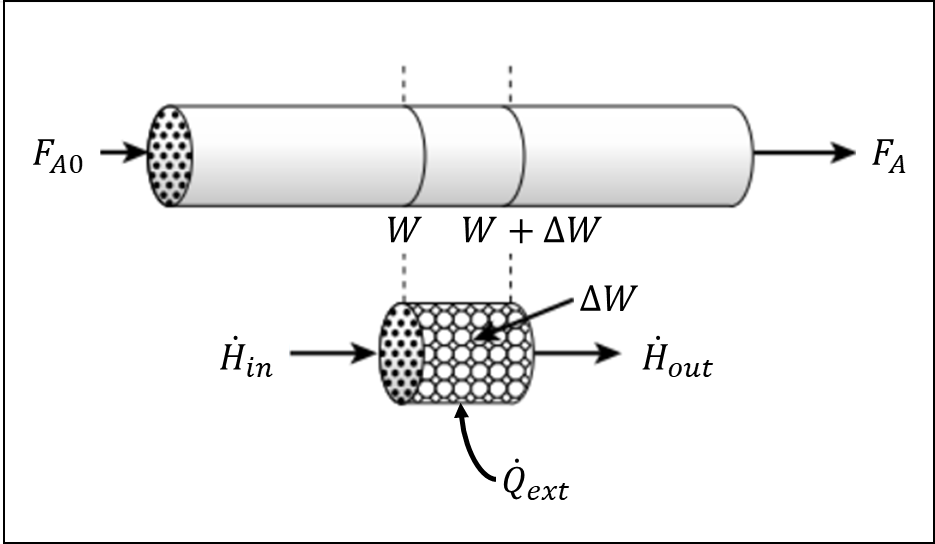


The energy balance on the selected control volume can be written as:

\begin{equation}
\dot{H}_{in} - \dot{H}_{out} + \dot{Q}_{ext} ΔV = Q_{accumulation}
\end{equation}

At steady state, $Q_{accumulation}=0$, leaving:
\begin{equation}
\dot{H}_{in} - \dot{H}_{out} + \dot{Q}_{ext} ΔV = 0
\end{equation}

Where
$\dot{H}_{in}$ and $\dot{H}_{out}$ are the enthalpies of the streams entering and leaving the control volume. And $\dot{Q}_{ext}$ is the heat added from external sources per unit volume. So that:

$\dot{H}_{in} =  \sum\limits_{comp,i} F_i \bar{H}_i \bigg|_{W}
$

$\dot{H}_{out} =  \sum\limits_{comp,i} F_i \bar{H}_i \bigg|_{W+ΔW}
$

$\dot{Q}_{ext} ΔV = \frac{\dot{Q}_{ext}}{ρ_B} ΔW
$

Combining,

\begin{equation}
\sum\limits_{comp,i} F_i \bar{H}_i \Big|_{W}
- \sum\limits_{comp,i} F_i \bar{H}_i \Big|_{W+ΔW}
+ \frac{\dot{Q}_{ext}}{ρ_B} ΔW = 0
\end{equation}

Dividing through by $ΔW$,

\begin{equation}
\sum\limits_{comp,i} \frac{F_i \bar{H}_i \Big|_{W}- F_i \bar{H}_i \Big|_{W+ΔW}}{ΔW}
+ \frac{\dot{Q}_{ext}}{ρ_B}= 0
\end{equation}

Taking the limit as $ΔW ⟶ ∞$,

\begin{equation}
 \frac{d}{dW} \left[ \sum\limits_{comp,i} F_i \bar{H}_i \right]
+ \frac{\dot{Q}_{ext}}{ρ_B}= 0
\end{equation}

Taking the derivative of the sum and applying the product rule to each term,

\begin{equation}
 \sum\limits_{comp,i} \left[ \frac{dF_i}{dW} \bar{H}_i + \frac{d\bar{H}_i}{dW} F_i \right]
+ \frac{\dot{Q}_{ext}}{ρ_B}= 0
\end{equation}

By definiton, $dF_i/dW = r'_i$. And taking component $A$ as a reference component in the reaction $A + \frac{b}{a} B ⟶ \frac{c}{a} C + \frac{d}{a} D$, the rate equations for other components can be written using their stoichiometric coefficients '$v_i$' (e.g. $v_B=b/a$). Thus:

\begin{equation}
\frac{dF_i}{dW} = v_i (-r'_A)
\end{equation}

Using the chain rule on the derivative $\frac{d\bar{H}_i}{dW}$,

\begin{equation}
\frac{d\bar{H}_i}{dW} = \frac{dT}{dW} \frac{d\bar{H}_i}{dT} = \frac{dT}{dW} \bar{C}_{p,i}
\end{equation}

Combining,

\begin{equation}
 \sum\limits_{comp,i} \bar{H}_i v_i (-r'_A)
+ \sum\limits_{comp,i} \frac{dT}{dW} F_i \bar{C}_{p,i}
+ \frac{\dot{Q}_{ext}}{ρ_B}= 0
\end{equation}

\begin{equation}
 -r'_A \sum\limits_{comp,i} \bar{H}_i v_i
+ \frac{dT}{dW} \sum\limits_{comp,i} F_i \bar{C}_{p,i}
+ \frac{\dot{Q}_{ext}}{ρ_B}= 0
\end{equation}

Substituting for the definition of heat of reaction ($ΔH_{rxn}=\sum\limits_{comp,i} \bar{H}_i v_i$) and rearranging,

\begin{equation}
 \frac{dT}{dW} = \frac{r'_A ΔH_{rxn} + \dot{Q}_{ext}/ρ_B}{\sum\limits_{comp,i} F_i \bar{C}_{p,i}}
\end{equation}

This can be interpreted as:

\begin{equation}
 \frac{dT}{dW} = \frac{\dot{Q}_{gen} + \dot{Q}_{added}}{C_{p,overall}}
\end{equation}

## 2. Solving the system of Equations Numerically

Solve using `scipy.integrate.solve_ivp()`

For information on using scipy:
https://ndcbe.github.io/data-and-computing/notebooks/07/Systems-of-Differential-Equations-and-Scipy.html


In the code below we declare all the known parameters and then create a function setting up the ODEs, before solving them with `scipy.integrate.solve_ivp()` Most of the code is prepared, but the equations derived in part 1 must be added as the student solution.

In [2]:
### BEGIN SOLUTION 
def pbr_odes(W, y):
    ''' Function that returns the RHS of the ODEs for the ODE solver
    Arguments:
        y: Vector of dependent variables
        W: Independent variable

    Returns:
        dydW: Vector of derivatives of dependent variables
    '''
    
    p, T, F_A, F_B, F_I = y
    dydW = np.zeros(len(y))

    # Energy equation parameters
    T_R = 300
    H_rxn = -20000
    C_pA = 160
    C_pB = 160
    C_pI = 18

    # Stoichiometry & rate law
    F_T = F_A + F_B + F_I
    C_T0 = 150 / 0.082 / T0
    C_A = C_T0 * F_A / F_T0 * T0 / T * p
    C_B = C_T0 * F_B / F_T0 * T0 / T * p
    C_I = C_T0 * F_I / F_T0 * T0 / T * p

    # Rate law & kinetic parameters
    R_E = 1.9872
    E = 10000
    k1 = 0.1 * np.exp(E / R_E * (1 / 300 - 1 / T))
    Kc = 1000 * np.exp(H_rxn / R_E * (1 / 300 - 1 / T))

    r_A = -(k1 / rho_b * (C_A - 1 / Kc * C_B))
    r_B = -r_A
    r_I = 0

    # Mole Balance Equations
    dF_AdW = r_A
    dF_BdW = r_B
    dF_IdW = r_I

    # Energy Balance Equation
    Fi_Cpi = F_A * C_pA + F_B * C_pB + F_I * C_pI
    delta_Cp = C_pB - C_pA
    Q_gen = r_A * (H_rxn + delta_Cp * (T - T_R))
    dTdW = Q_gen / Fi_Cpi

    # Pressure Drop Equation
    dpdW = -alpha / (2 * p) * T / T0 * F_T / F_T0

    dydW = np.array([dpdW, dTdW, dF_AdW, dF_BdW, dF_IdW])
    return dydW / rho_b

# Inlet conditions
theta_I = 2
theta_B = 0
C_A0 = 2
C_B0 = theta_B * C_A0
C_I0 = theta_I * C_A0

F_A0 = 5
F_I0 = theta_I * F_A0
F_B0 = 0
F_T0 = F_A0 + F_B0 + F_I0
T0 = 300

# Initial conditions
y0 = [1, T0, F_A0, F_B0, F_I0]

# Reactor properties
rho_b = 1.2
alpha = 0.02 / rho_b
V = 40

# Solving ODEs
sol = sp.solve_ivp(pbr_odes, [0, V], y0, method='RK45')
### END SOLUTIONS

## 3. Analysis of Results

## 3a. Visualization


For information on making quality plots see: https://ndcbe.github.io/data-and-computing/notebooks/01/Matplotlib.html


 i)  Write a function that calculates $X$, $X_e$ and $-r_A$ for a given set of parameters of interest ($T_0$, $\Theta_I$, $\alpha$, $C_{p,A}$, $C_{p,B}$, $C_{p,I}$)

Much of the coding is provided, but to be completed sections include:

- Equations from part 1 must be added to pbr_odes_mod as was done in part 2
- Calculations of conversion, reaction rate, and equilibrium conversion.


In [3]:
### BEGIN SOLUTION 
def solve_pbr(param):
    ''' A function that solves the PBR model given a set of parameters of interest and returns conversions, reaction rate temperature and pressure
    Arguments:
        param: Vector of parameters of interest (to be varied)

    Returns:
        V_range: reactor volume values solution is stored at [dm^3] - vector
        X_prof: conversion profile of component A [-] - vector
        Xe_prof: equilibrium conversion profile [-] - vector
        rA_prof: rate of production of component A [mol A/(min.dm^3)] - vector
        T: temperature profile [K] - vector
        p: pressure ratio profile [-] - vector

    '''

    # Extract parameters of interest
    T0, theta_I, alpha, C_pA, C_pB, C_pI = param

    # Define a modified version of 'pbr_odes' that takes parameters as arguments
    def pbr_odes_mod(W, y):
        ''' Function that returns the RHS of the ODEs for the ODE solver and takes T0, theta_I, alpha, C_pA, C_pB, C_p from the parent function
        Arguments:
            y: Vector of dependent variables
            W: Independent variable

        Returns:
            dydW: Vector of derivatives of dependent variables
        '''
        
        p, T, F_A, F_B, F_I = y

        # Energy equation parameters
        T_R = 300      # Reference temperature [K]
        H_rxn = -20000  # Heat of reaction at 300 K [cal/mol]

        # Calculate concentrations and rates
        F_T = F_A + F_B + F_I
        C_T0 = 150 / 0.082 / T0
        C_A = C_T0 * F_A / F_T0 * T0 / T * p
        C_B = C_T0 * F_B / F_T0 * T0 / T * p

        # Rate law & kinetic parameters
        R_E = 1.9872
        E = 10000
        k1 = 0.1 * np.exp(E/R_E * (1/300 - 1/T))
        Kc = 1000 * np.exp(H_rxn/R_E * (1/300 - 1/T))

        r_A = -(k1/rho_b * (C_A - 1/Kc * C_B))
        r_B = -r_A
        r_I = 0

        # Mole Balance Equations
        dF_AdW = r_A
        dF_BdW = r_B
        dF_IdW = r_I

        # Energy Balance Equation
        Fi_Cpi = F_A * C_pA + F_B * C_pB + F_I * C_pI
        delta_Cp = C_pB - C_pA
        Q_gen = r_A * (H_rxn + delta_Cp * (T - T_R))
        dTdW = Q_gen / Fi_Cpi

        # Pressure Drop Equation
        dpdW = -alpha / (2 * p) * T / T0 * F_T / F_T0

        return np.array([dpdW, dTdW, dF_AdW, dF_BdW, dF_IdW]) / rho_b

    # Inlet conditions
    theta_B = 0
    C_A0 = 2
    C_B0 = theta_B * C_A0
    C_I0 = theta_I * C_A0
    F_A0 = 5
    F_I0 = theta_I * F_A0
    F_B0 = 0
    F_T0 = F_A0 + F_B0 + F_I0

    y0 = [1, T0, F_A0, F_B0, F_I0]

    # Reactor properties
    rho_b = 1.2
    alpha = 0.02 / rho_b
    V = 40
    H_rxn = -20000
    R_E = 1.9872
    E = 10000

    # Solve the system of ODEs
    sol = sp.solve_ivp(pbr_odes_mod, [0, V], y0, method='RK45', t_eval=np.arange(0, V, step=0.5))

    # Extract solutions
    V_range = sol.t
    p, T, F_A, F_B, F_I = sol.y

    # Calculate conversion
    X_prof = (F_A - F_A0) / F_A0

    # Calculate reaction rate
    F_T = F_A + F_B + F_I
    C_T0 = 150 / 0.082 / T0
    C_A = C_T0 * F_A / F_T0 * T0 / T * p
    C_B = C_T0 * F_B / F_T0 * T0 / T * p
    k1 = 0.1 * np.exp(E/R_E * (1/300 - 1/T))
    Kc = 1000 * np.exp(H_rxn/R_E * (1/300 - 1/T))
    rA_prof = -(k1 / rho_b * (C_A - 1/Kc * C_B))

    # Calculate equilibrium conversion
    Xe_prof = Kc / (1 + Kc)

    return V_range, X_prof, Xe_prof, rA_prof, T, p
### END SOLUTIONS


In [4]:
R_E = 1.9872
E = 10000
T = 350

0.1 * np.exp(-E/R_E * (1/300 - 1/T))


0.009105526690642225

 ii) Create a 2x2 subplot figure for conversion ($X$ and $X_e$), $T$, $p$ and $-r_A$ profiles, (all plotted vs reactor volume) in distinct suplots. Use the written function for the solution from 2b

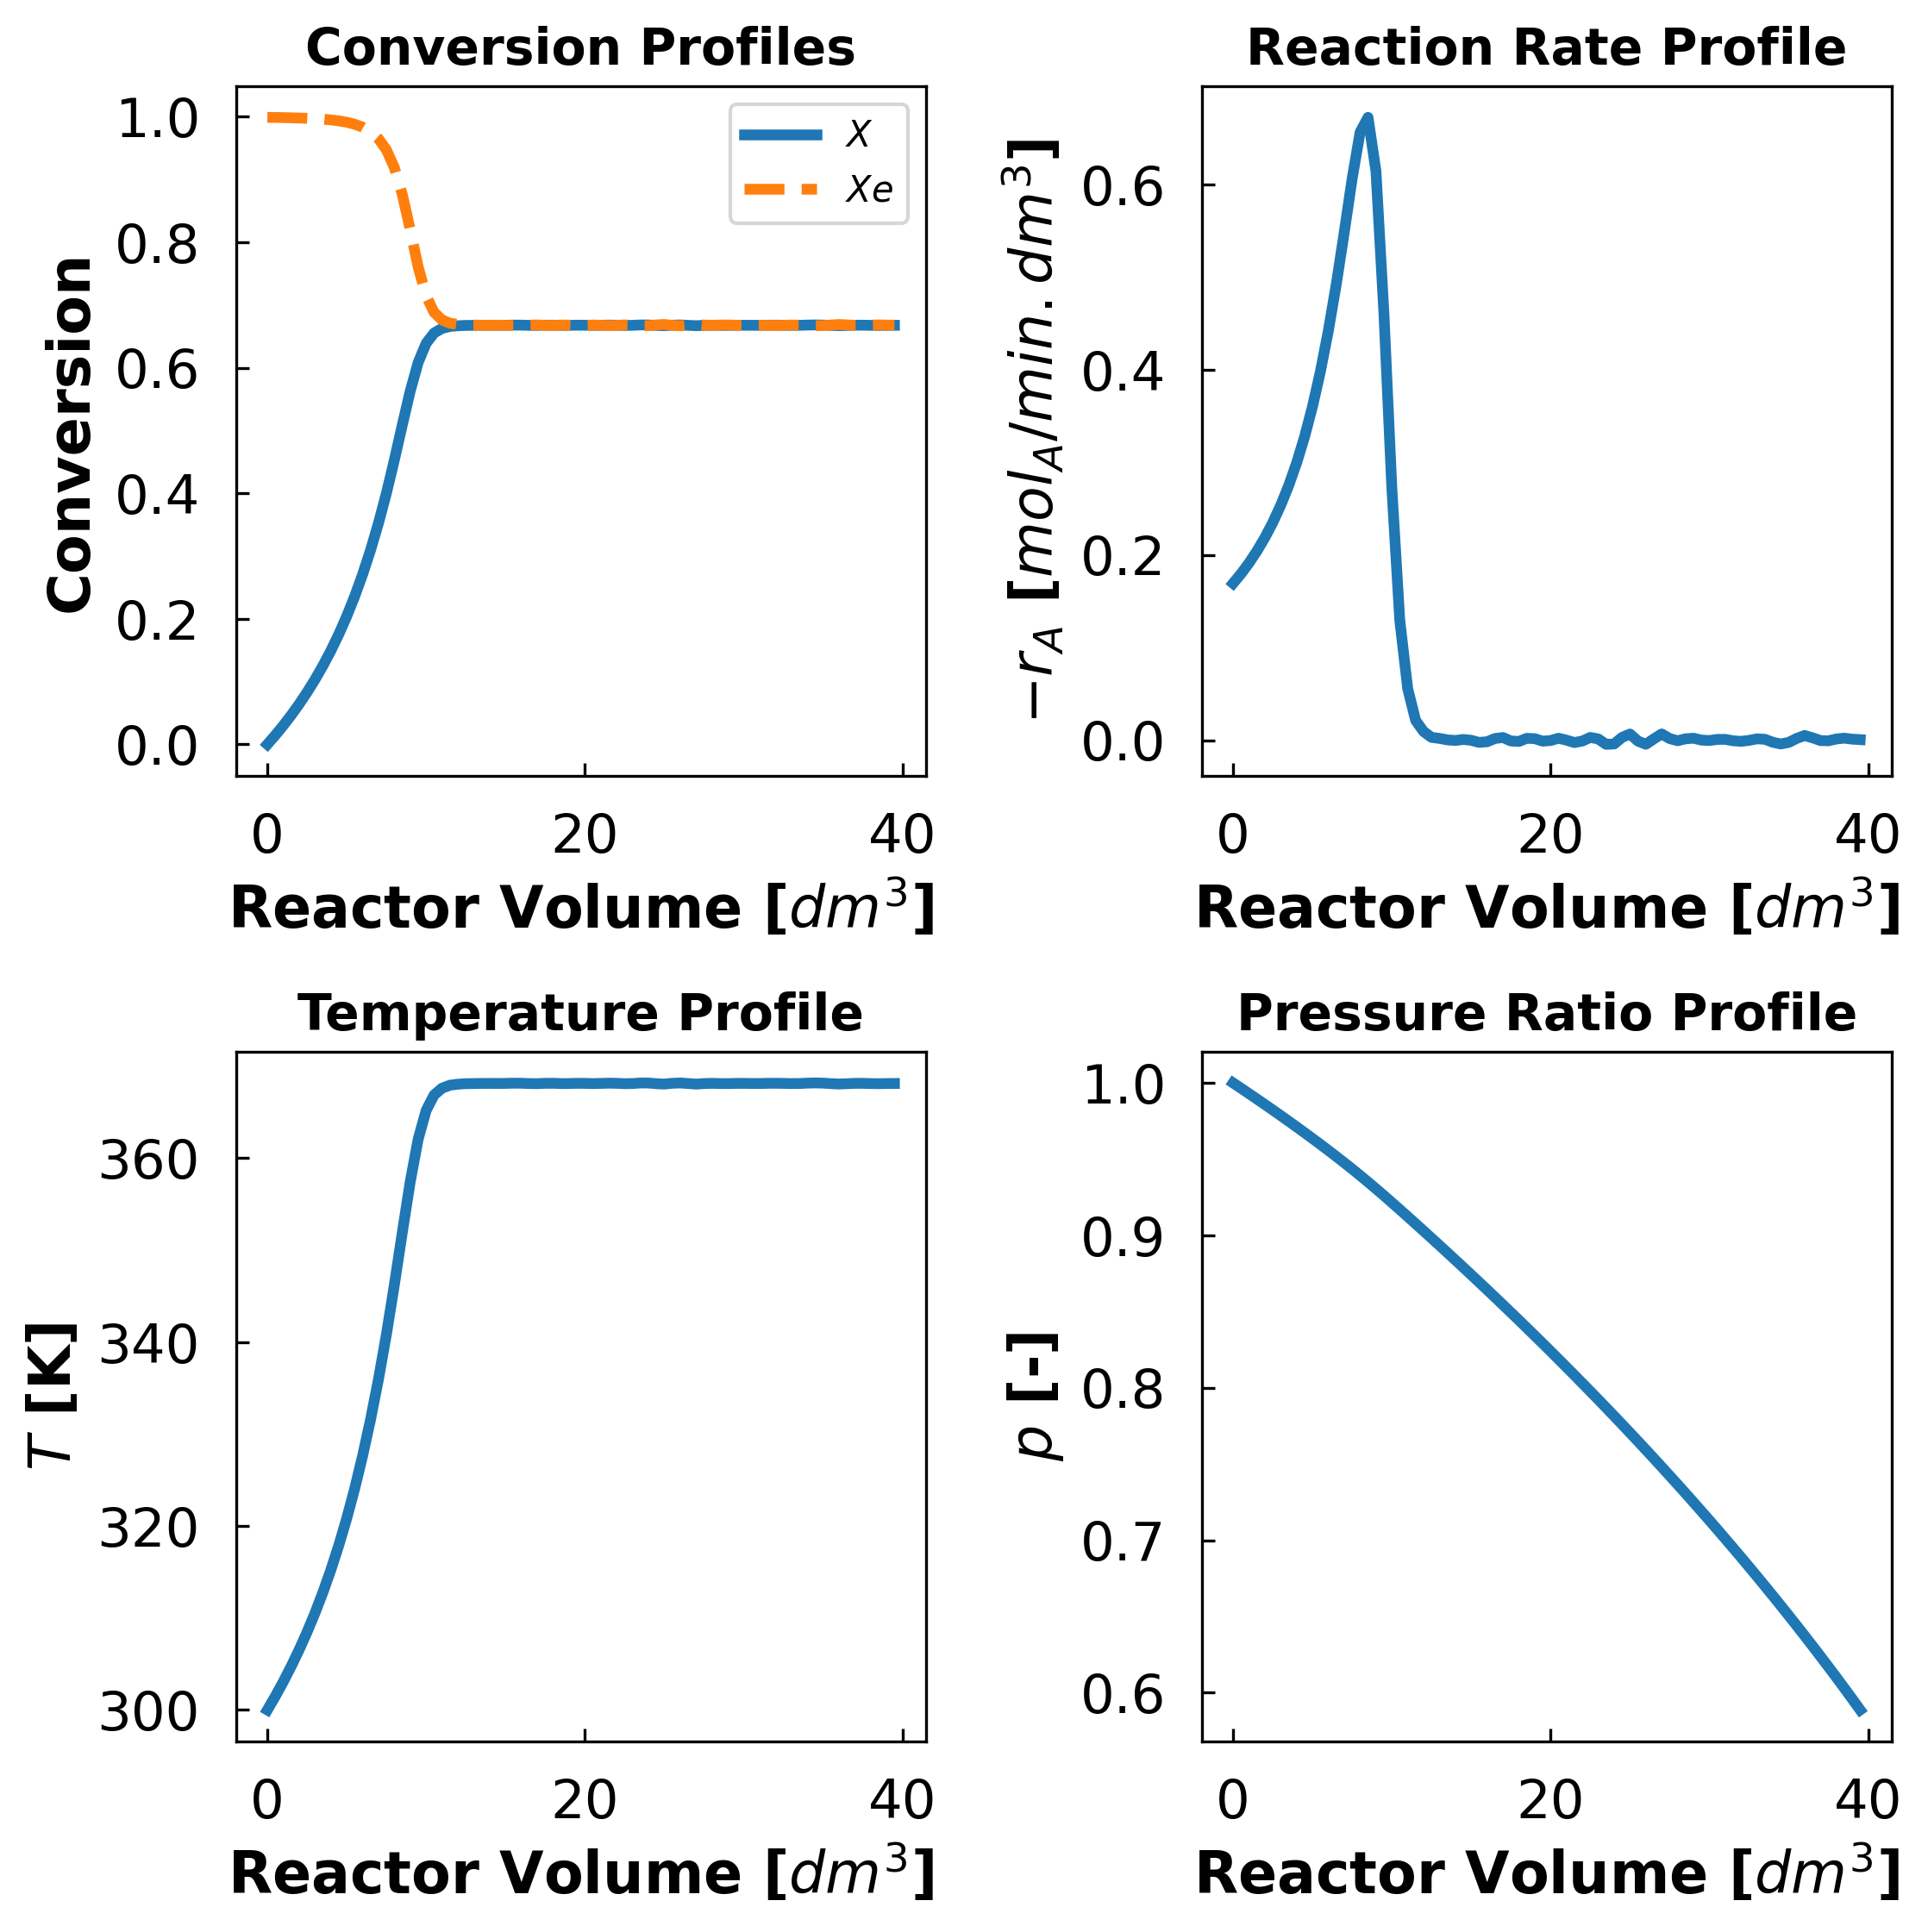

In [5]:
### BEGIN SOLUTION 
# Defining parameters
params = [
    300,    # Inlet temperature T0 [K]
    2,      # Ratio of inert concentration to concentration of 'A' theta_I [mol_I/mol_A]
    0.02,   # Pressure ratio drop per unit catalyst mass alpha
    160,    # Heat capacity at constant pressure of component A C_pA [cal/mol.K]
    160,    # Heat capacity at constant pressure of component B C_pB [cal/mol.K]
    18,     # Heat capacity at constant pressure of component I C_pI [cal/mol.K]
]

# Solving PBR model
V_range, X, Xe, rA, T, p = solve_pbr(params)

# Plotting
# Setting plot parameters
lin_wdth = 3
mrk_siz = 8

fig, axs = plt.subplots(2, 2, dpi=300, figsize=(8, 8))

# Conversion Profiles
axs[0, 0].plot(V_range, -X, '-', label=r'$X$', linewidth=lin_wdth, markersize=mrk_siz)
axs[0, 0].plot(V_range, Xe, '--', label=r'$Xe$', linewidth=lin_wdth, markersize=mrk_siz)
axs[0, 0].set_title('Conversion Profiles', fontsize=14, fontweight='bold')
axs[0, 0].set_xlabel('Reactor Volume [$dm^3$]', fontsize=16, fontweight='bold')
axs[0, 0].set_ylabel('Conversion', fontsize=16, fontweight='bold')
axs[0, 0].tick_params(axis='both', which='major', direction='in', pad=10, labelsize=15)
axs[0, 0].legend()

# Reaction Rate Profile
axs[0, 1].plot(V_range, -rA, '-', linewidth=lin_wdth, markersize=mrk_siz)
axs[0, 1].set_title('Reaction Rate Profile', fontsize=14, fontweight='bold')
axs[0, 1].set_xlabel('Reactor Volume [$dm^3$]', fontsize=16, fontweight='bold')
axs[0, 1].set_ylabel('$-r_A$ [$mol_A/min.dm^3$]', fontsize=16, fontweight='bold')
axs[0, 1].tick_params(axis='both', which='major', direction='in', pad=10, labelsize=15)

# Temperature Profile
axs[1, 0].plot(V_range, T, '-', linewidth=lin_wdth, markersize=mrk_siz)
axs[1, 0].set_title('Temperature Profile', fontsize=14, fontweight='bold')
axs[1, 0].set_xlabel('Reactor Volume [$dm^3$]', fontsize=16, fontweight='bold')
axs[1, 0].set_ylabel('$T$ [K]', fontsize=16, fontweight='bold')
axs[1, 0].tick_params(axis='both', which='major', direction='in', pad=10, labelsize=15)

# Pressure Ratio Profile
axs[1, 1].plot(V_range, p, '-', linewidth=lin_wdth, markersize=mrk_siz)
axs[1, 1].set_title('Pressure Ratio Profile', fontsize=14, fontweight='bold')
axs[1, 1].set_xlabel('Reactor Volume [$dm^3$]', fontsize=16, fontweight='bold')
axs[1, 1].set_ylabel('$p$ [-]', fontsize=16, fontweight='bold')
axs[1, 1].tick_params(axis='both', which='major', direction='in', pad=10, labelsize=15)

# Set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()
### END SOLUTIONS

## 3b. Effect of Heat Capacities


 i) Solve for the case where $C_{P,B}$ is varied and plot conversion and temperature profiles for those cases

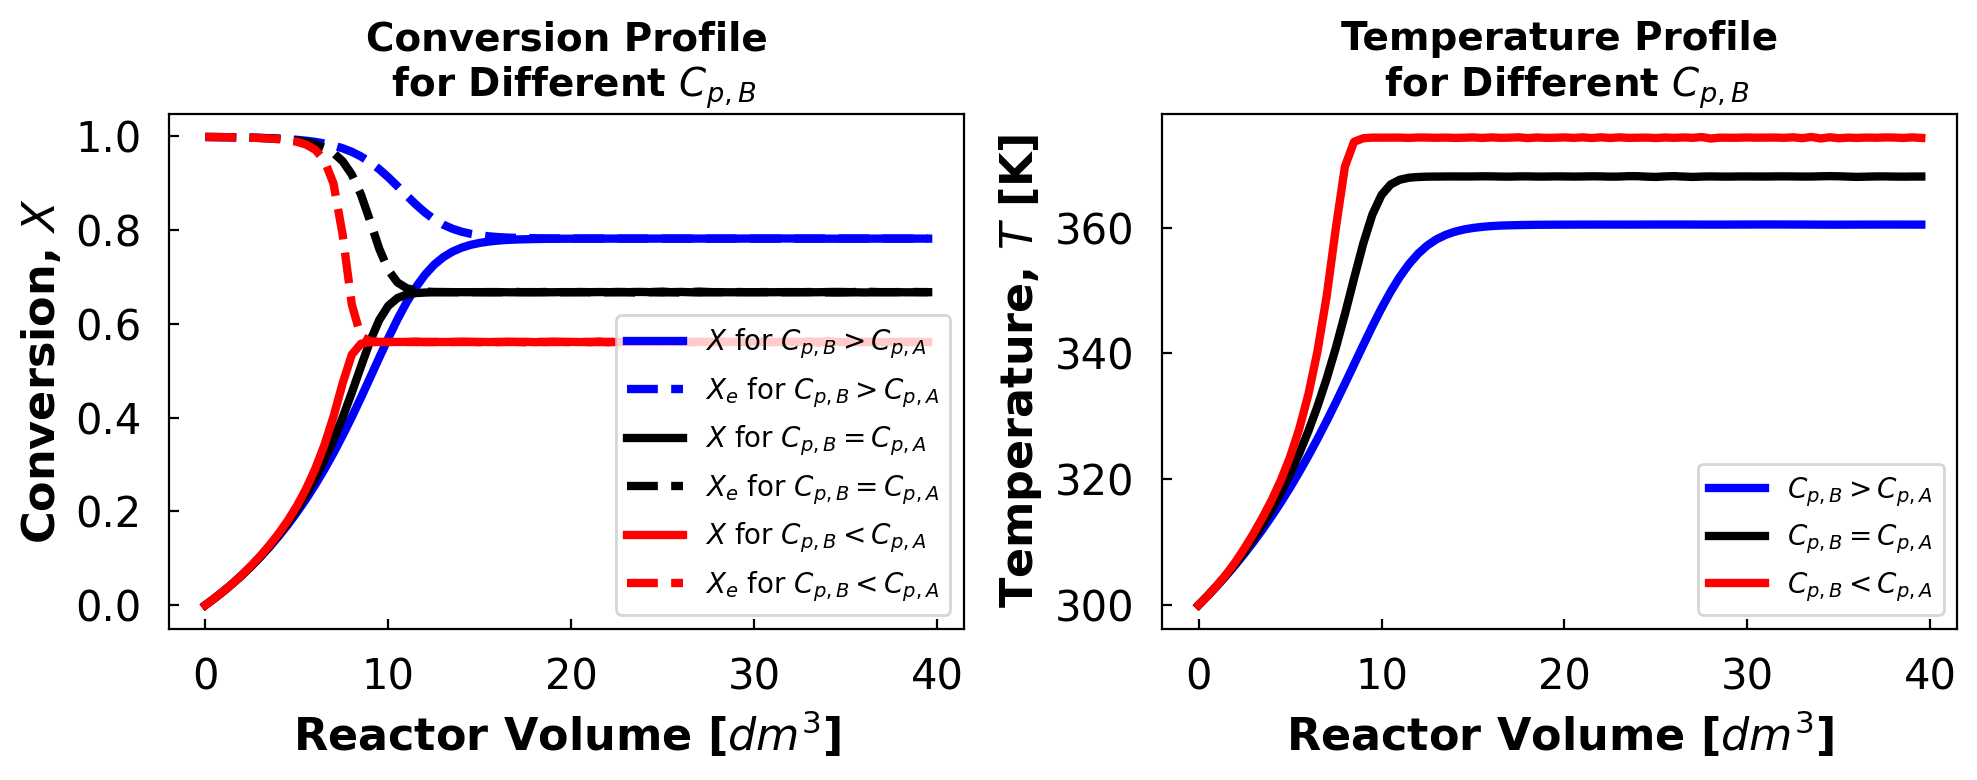

In [6]:
### BEGIN SOLUTION 
# Setting up variables
labels = [
    "$C_{p,B} > C_{p,A}$",
    "$C_{p,B} = C_{p,A}$",
    "$C_{p,B} < C_{p,A}$"
]

C_pB_levels = [240, 160, 80]

colors = ["blue", "black", "red"]

# Creating a single figure with two subplots
fig, (axs1, axs2) = plt.subplots(1, 2, dpi=200, figsize=(10, 4))

# Plotting for different C_p,B
for i in range(len(labels)):
    params = [
        300,    # [K] - T0
        2,      # [mol_I/mol_A] - theta_I
        0.02,   # alpha,
        160,    # [cal/mol.K] - C_pA,
        C_pB_levels[i],    # [cal/mol.K] - C_pB,
        18,     # [cal/mol.K] - C_pI,
    ]

    V_range, X, Xe, rA, T, p = solve_pbr(params)

    axs1.plot(
        V_range, -X,
        label="$X$ for " + labels[i],
        linewidth=lin_wdth,
        color=colors[i]
    )

    axs1.plot(
        V_range, Xe,
        '--',
        label="$X_e$ for " + labels[i],
        linewidth=lin_wdth,
        color=colors[i]
    )

    axs2.plot(
        V_range, T,
        label=labels[i],
        linewidth=lin_wdth,
        color=colors[i]
    )

# Additional plot elements for the first subplot
axs1.set_title('Conversion Profile\n for Different $C_{p,B}$', fontsize=14, fontweight='bold')
axs1.set_xlabel('Reactor Volume [$dm^3$]', fontsize=16, fontweight='bold')
axs1.set_ylabel("Conversion, $X$", fontsize=16, fontweight='bold')
axs1.tick_params(axis='both', which='major', direction='in', pad=10, labelsize=15)
axs1.legend()

# Additional plot elements for the second subplot
axs2.set_title('Temperature Profile\n for Different $C_{p,B}$', fontsize=14, fontweight='bold')
axs2.set_xlabel('Reactor Volume [$dm^3$]', fontsize=16, fontweight='bold')
axs2.set_ylabel('Temperature, $T$ [K]', fontsize=16, fontweight='bold')
axs2.tick_params(axis='both', which='major', direction='in', pad=10, labelsize=15)
axs2.legend()

# Add space between the subplots to avoid overlapping
plt.tight_layout()

# Display the figure
plt.show()
### END SOLUTIONS

In [7]:
### BEGIN SOLUTION 
def plot_profiles(x_name, x_ind, x_levels, y_plot, labels, LOUD=True):
    '''
    Creates a subplot of conversion profile and the profile of a property y_plot for different values of 'x'.

    Arguments:
        x_name: name of the variable of interest (String)
        x_ind: index of variable 'x' in the parameter list 'param' (integer)
        x_levels: values of 'x' to loop over (vector)
        y_plot: name of desired profile in the plot
        labels: labels for plots

    Returns:
        None
    '''

    assert len(x_levels) == len(labels), 'List of labels and levels must be of the same length'
    assert y_plot in {'Rate', 'Temperature', 'Pressure'}, 'y_plot variable can only take the values "Rate" or "Temperature" or "Pressure"'

    # Create a figure for subplot
    fig, axs = plt.subplots(1, 2, dpi=300, figsize=(10, 4))

    if y_plot == 'Rate':
        y_index = 3
        ylabel = '$-r_A$ [$mol / kg_{cat} . min$]'
        title = f'Rate of Consumption of A Profiles\nfor Different {x_name}'
    elif y_plot == 'Temperature':
        y_index = 4
        ylabel = 'Temperature, $T$ [K]'
        title = f'Temperature Profiles\nfor Different {x_name}'
    elif y_plot == 'Pressure':
        y_index = 5
        ylabel = 'Pressure Ratio, $p$'
        title = f'Pressure Ratio Profiles\nfor Different {x_name}'

    # Initialize the list of parameters
    params = [
        300,    # [K] - T0
        2,      # [mol_I/mol_A] - theta_I
        0.02,   # alpha,
        160,    # [cal/mol.K] - C_pA,
        160,    # [cal/mol.K] - C_pB,
        18,     # [cal/mol.K] - C_pI,
    ]

    for i in range(len(labels)):
        params[x_ind] = x_levels[i]  # Update the variable of interest in the parameter list

        results = solve_pbr(params)

        V_range, X, Xe, rA, T, p = results

        if LOUD:
            print(f"The exit conversion at {x_name} = {x_levels[i]} is {round(-X[-1]*100, 2)}%\n")

        axs[0].plot(V_range, -X, label="$X$ for " + labels[i], linewidth=lin_wdth, color=colors[i])
        axs[0].plot(V_range, Xe, '--', label="$X_e$ for " + labels[i], linewidth=lin_wdth, color=colors[i])
        axs[1].plot(V_range, np.abs(results[y_index]), label=labels[i], linewidth=lin_wdth, color=colors[i])

    # Additional plot elements for the first subplot
    axs[0].set_title(f'Conversion Profile for\nDifferent {x_name}', fontsize=14, fontweight='bold')
    axs[0].set_xlabel('Reactor Volume [$dm^3$]', fontsize=16, fontweight='bold')
    axs[0].set_ylabel("Conversion, $X$", fontsize=16, fontweight='bold')
    axs[0].tick_params(axis='both', which='major', direction='in', pad=10, labelsize=15)
    axs[0].legend()

    # Additional plot elements for the second subplot
    axs[1].set_title(title, fontsize=14, fontweight='bold')
    axs[1].set_xlabel('Reactor Volume [$dm^3$]', fontsize=16, fontweight='bold')
    axs[1].set_ylabel(ylabel, fontsize=16, fontweight='bold')
    axs[1].tick_params(axis='both', which='major', direction='in', pad=10, labelsize=15)
    axs[1].legend()

    # Set the spacing between subplots
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()
### END SOLUTIONS

The exit conversion at $C_{p,B}$ = 240 is 78.2%

The exit conversion at $C_{p,B}$ = 160 is 66.77%

The exit conversion at $C_{p,B}$ = 80 is 56.12%



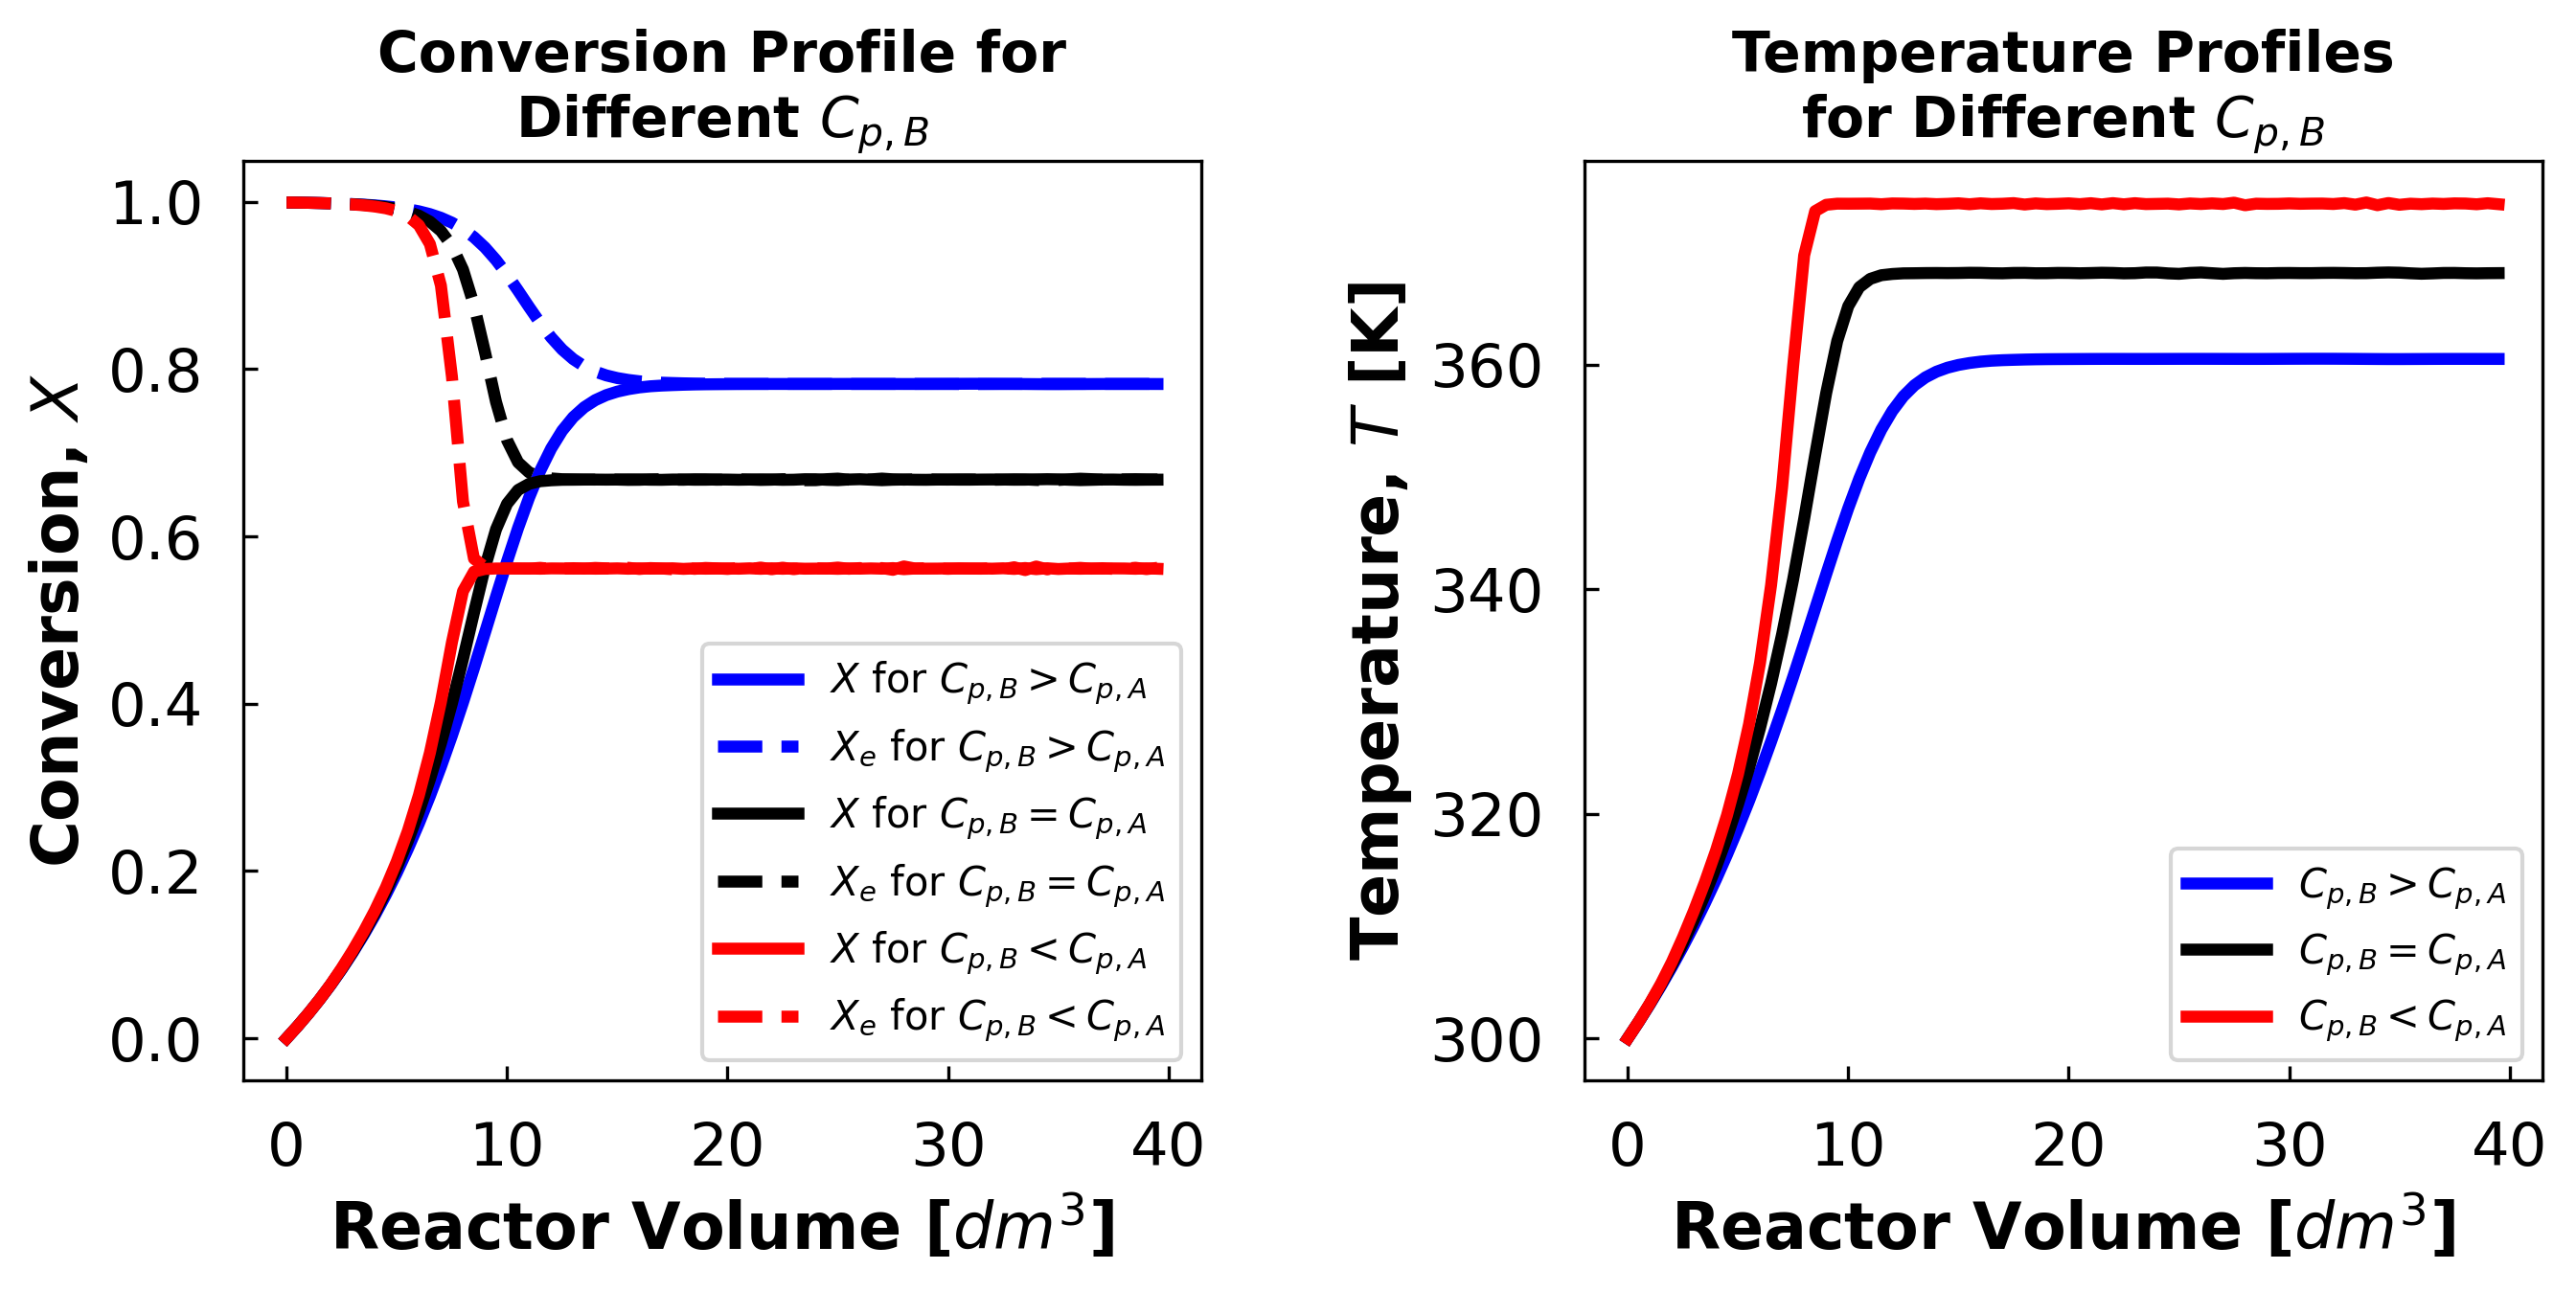

In [8]:
### BEGIN SOLUTION 
# testing the generalized plotting function
labels =  [
    "$C_{p,B} > C_{p,A}$",
    "$C_{p,B} = C_{p,A}$",
    "$C_{p,B} < C_{p,A}$"
]

C_pB_levels = [240, 160, 80]

# param = [T0, theta_I, alpha, C_pA, C_pB, C_pI]

plot_profiles('$C_{p,B}$', 4, C_pB_levels, 'Temperature', labels)
### END SOLUTION 

 ii) Comment on the effect of having $ΔC_P \neq 0$ (compare plots 3b and 3c)

A higher product heat capacity is beneficial in all cases for this reaction. This is because the reaction is limited by equilibrium, and the equilibrium conversion is negatively affected by temperature. When you have a product with a high heat capacity, it acts as a heat sink. This prevents the reaction mixture temperature from rising easily.

As a result, this prevents the equilibrium conversion from dropping deeper into the reactor. This, in turn, allows exit conversion to reach larger values.

## 3c. Effect of Pressure Drop


 i) Solve and plot for the case where pressure drop is ignored ($\alpha = 0 \Rightarrow dp/dW=0$)

The exit conversion at α = 0 is 66.77%

The exit conversion at α = 0.01 is 66.77%

The exit conversion at α = 0.02 is 66.77%



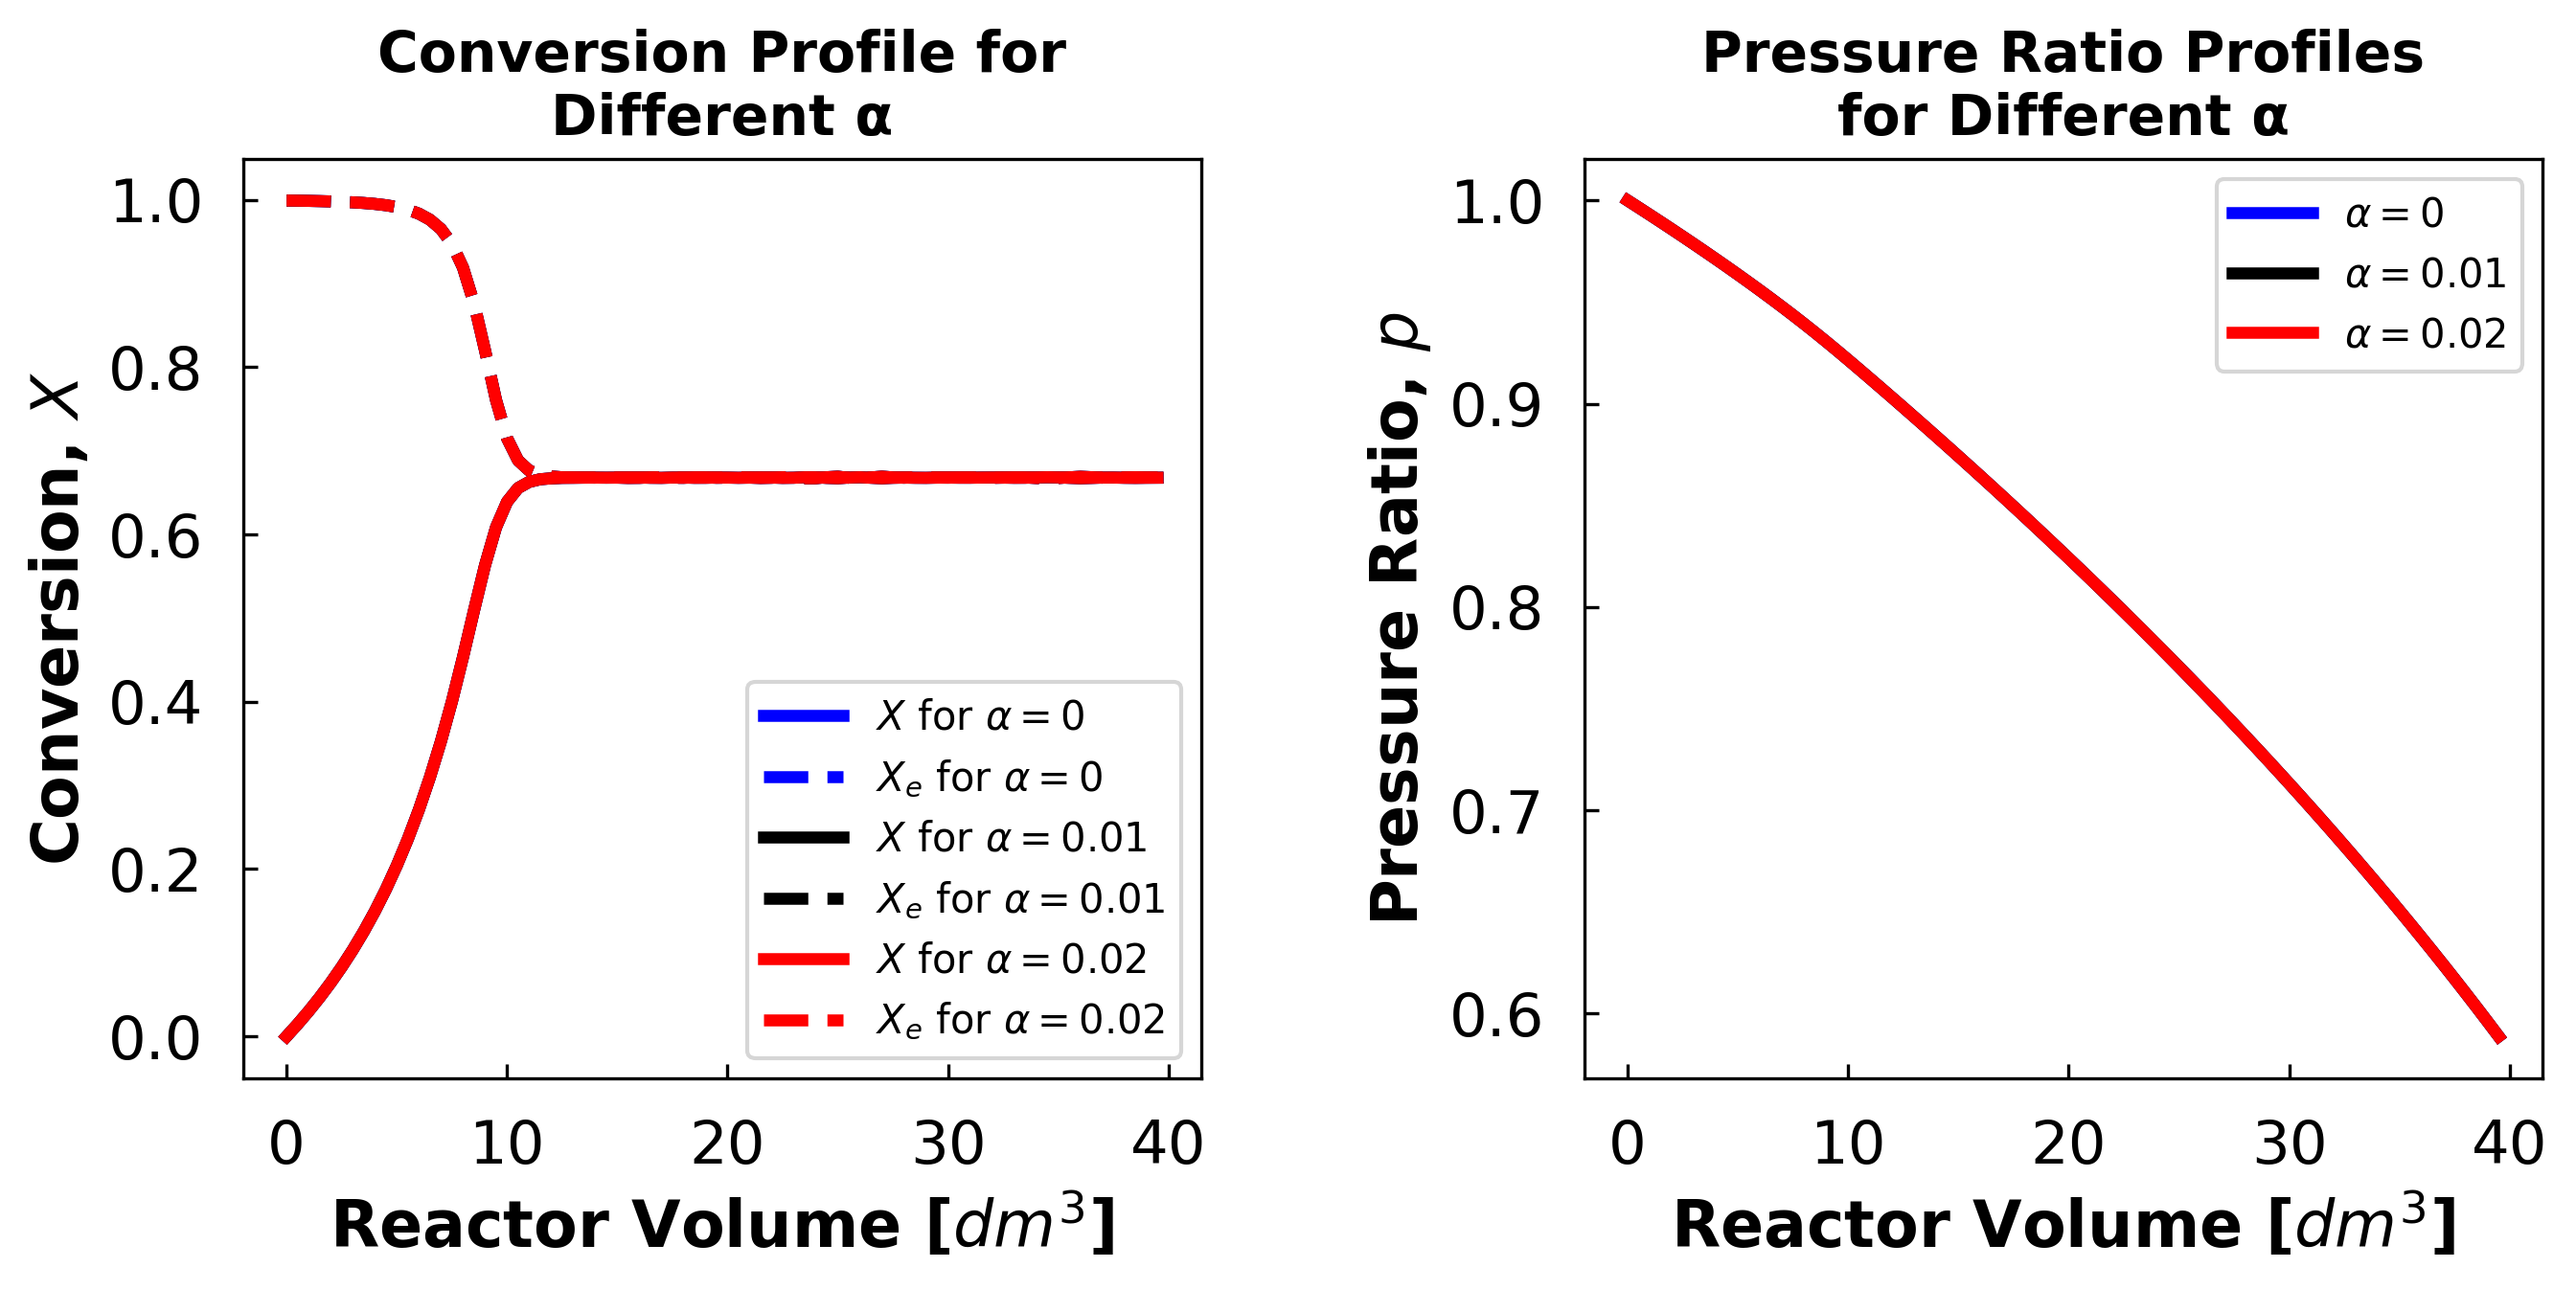

In [9]:
### BEGIN SOLUTION 
# Setting up variables
labels =  [
    r"$\alpha = 0$",
    r"$\alpha = 0.01$",
    r"$\alpha = 0.02$"
]

alpha_levels = [0, 0.01, 0.02]

colors = ["blue", "black", "red"]

### BEGIN SOLUTIONS

# param = [T0, theta_I, alpha, C_pA, C_pB, C_pI]

plot_profiles('α', 2, alpha_levels, 'Pressure', labels, LOUD=True)
### END SOLUTIONS

##### ii) Comment on the effect of including pressure drop

The effect of omitting pressure drop is very small in this case. This is because the equilibrium position of this reaction is not affected by pressure.

Le Chatelier's principle states that increasing pressure should push the equilibrium position to whichever side of the reaction has fewer moles. However, this reaction has the same number of moles on both sides ($A + I ⟷ B + I$).

## 4. Optimal Way to Control Reactor Temperature


## 4a. Effect of $Θ_I$

Solve for a set of cases where the fraction of inerts in the inlet varies $Θ_I=[0,10]$ and analyze the effect of the fraction of inerts on the exit conversion.

 i) Solve for a set of fraction of inerts (set of thetas) using solve_pbr. Hint: Use a for-loop



In [10]:
### BEGIN SOLUTION 
import warnings
warnings.simplefilter('ignore')

# List of theta_I values
Theta0_list = np.arange(0, 10, 0.1)
Theta0_list[0] = 1

# Initialize an empty list to store resulting conversions
conversion_for_theta = []

# Solve for different theta_I values and store the final conversions
for theta_I in Theta0_list:
    params = [
        300,             # Initial temperature [K] - T0
        theta_I,         # Initial moles of I per moles of A - theta_I
        0.02,            # Alpha
        160,             # Heat capacity of A [cal/mol.K] - C_pA
        160,             # Heat capacity of B [cal/mol.K] - C_pB
        18,              # Heat capacity of I [cal/mol.K] - C_pI
    ]
    V_range, X, Xe, rA, T, p = solve_pbr(params)
    
    # Append the final conversion value to the list of resulting conversions
    conversion_for_theta.append(-X[-1])

# Rename the list for resulting conversions
conversion_for_theta_list = list(conversion_for_theta)
### END SOLUTION 

 ii) Plot exit conversion Xout vs Theta Initial and comment on the effect of inert concentration on exit conversion. (4-6 sentences)

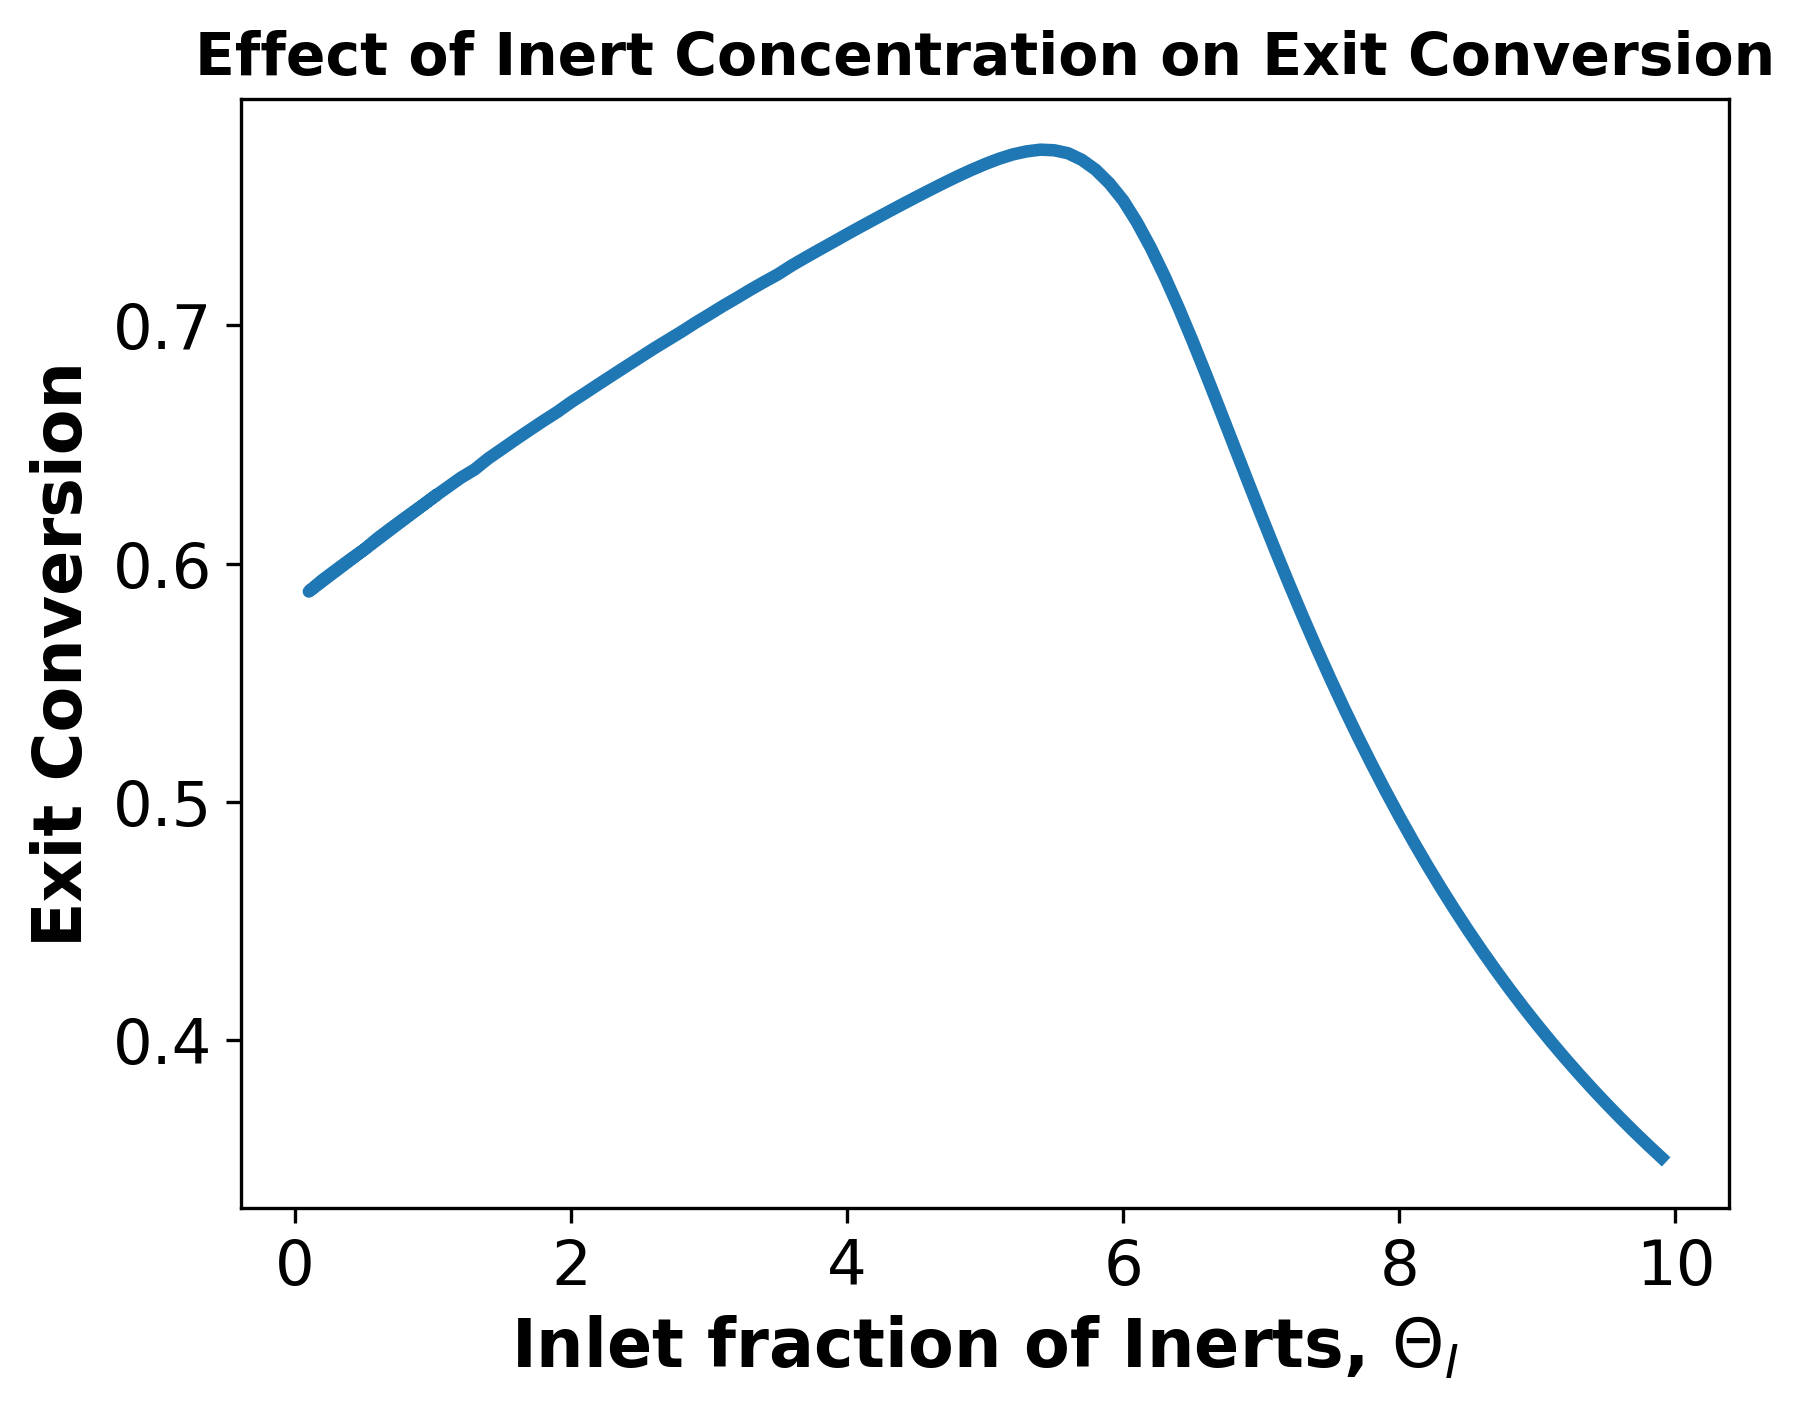

In [21]:
#plotting the exit conversion vs theta (ratio of inert to reactive species)

### BEGIN SOLUTIONS
plt.plot(
    Theta0_list,
   conversion_for_theta_list,
    linewidth = lin_wdth,
    )

# x and y axis labels
plt.xlabel('Inlet fraction of Inerts, $\Theta_I$', fontsize = 16, fontweight = 'bold')
plt.ylabel('Exit Conversion', fontsize = 16, fontweight = 'bold')

# plot title
plt.title("Effect of Inert Concentration on Exit Conversion", fontsize = 14, fontweight = 'bold')

# tick font sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.gcf().set_dpi(300)
plt.show()
### END SOLUTIONS

Describe your Observation here:

1. Fill in
2. Fill in

Answers: The plot shows that the exit conversion in a chemical reaction is influenced by the ratio of inert to reactive species, denoted as $\Theta_I$. At low $\Theta_I$, increasing inert gas concentration enhances conversion due to its heat-sinking effect. However, beyond a certain point, further increases in $\Theta_I$ reduce conversion because an excessive ratio of inert to reactive species limits interaction and reaction rate. This plot highlights the balance between heat absorption and dilution effects of inert gases on chemical conversion.

##### Let's explore the observed exit conversion trend resulting from different inert fractions:

At low $\Theta_I$ values (0, 2, and 4), plotting conversion profiles (X and Xe) against reactor volume reveals that increasing inert fractions lead to lower temperatures and higher conversion. This behavior can be attributed to inert gases acting as heat sinks, favoring the reaction's progress.

Conversely, at high $\Theta_I$ values (6, 8, and 10), examining conversion profiles and the rate of consumption of A against reactor volume shows a decline in the rate of consumption and exit conversion as inert fractions rise. This outcome occurs because an excess of inert species restricts the availability of reactive components, impeding the reaction rate and decreasing conversion.

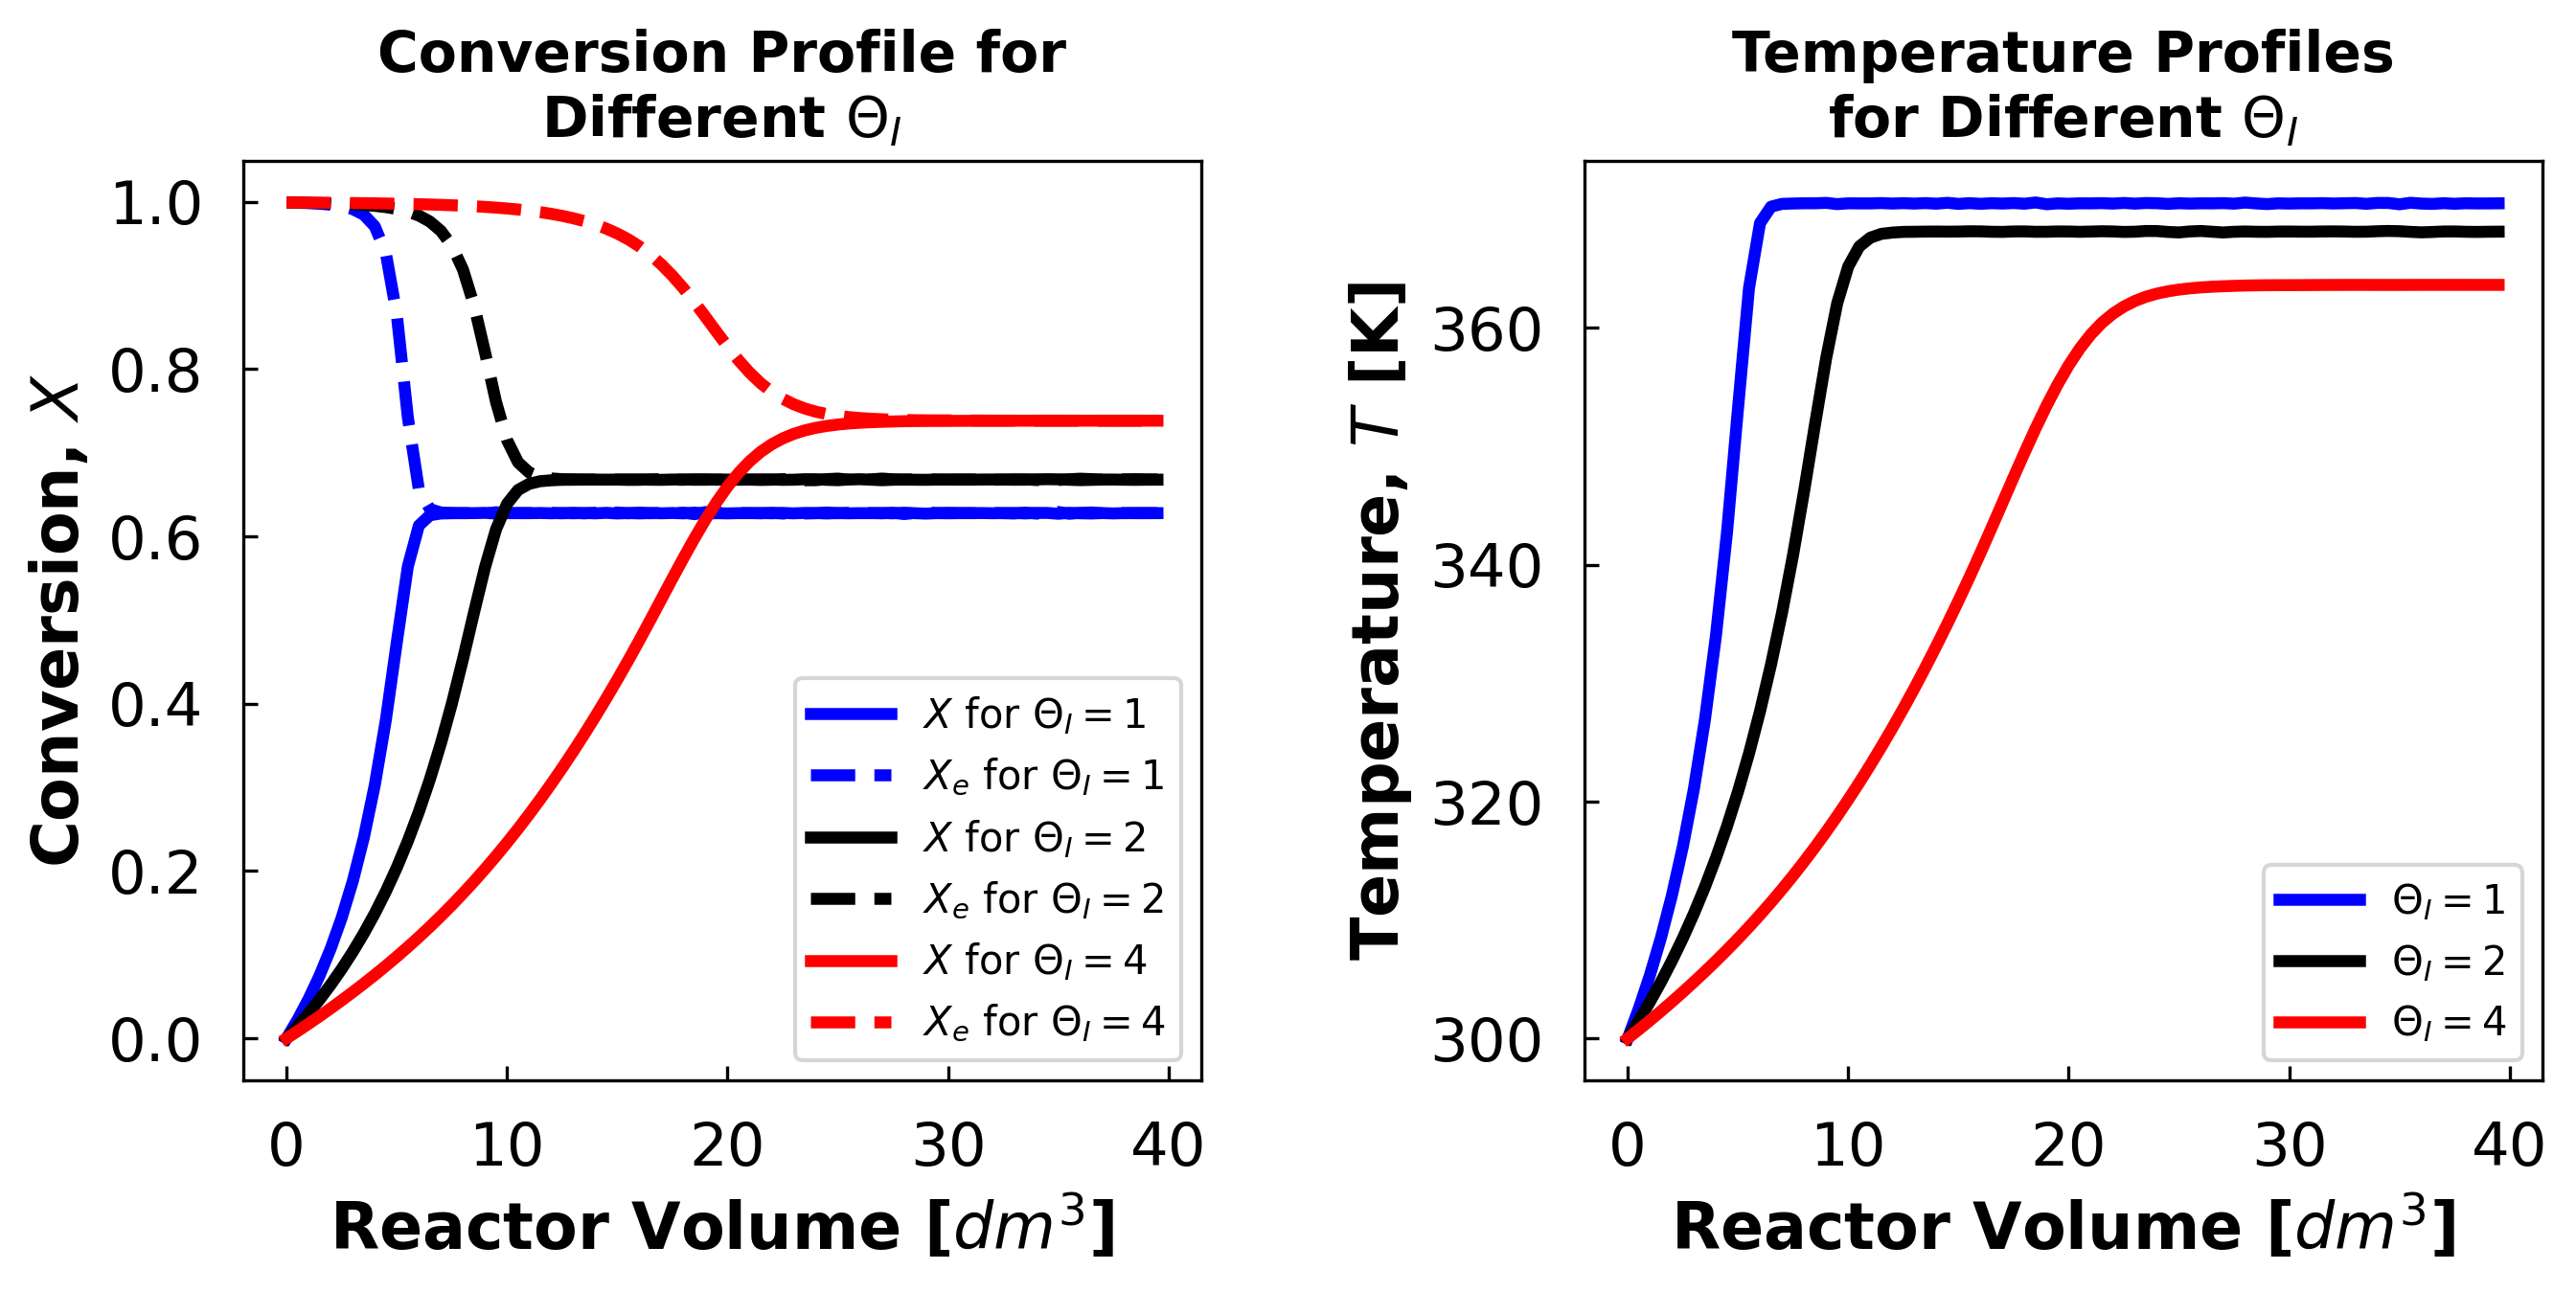

In [12]:
### BEGIN SOLUTION 
# List of thetas values we are examining
theta0_list = [1, 2, 4]

# Creating a list of labels for plot labels
labels = [
    r"$\Theta_I = 1$",
    r"$\Theta_I = 2$",
    r"$\Theta_I = 4$"
]

# Parameters: [T0, theta_I, alpha, C_pA, C_pB, C_pI]
# Plot temperature profiles for different Θ_I values
plot_profiles('$\Theta_I$', 1, theta0_list, 'Temperature', labels, LOUD=False)
### END SOLUTION 

### Why we could have a runtime error from the plot

A runtime error occurs when the theta value is set to 0, leading to a divide-by-zero issue in our scalar division within the formulas. However, by adjusting the value to 1, the errors vanish.

iii) Discussion on Low Theta Plots:

In the plots at low inert concentrations, we observe that equilibrium is reached at higher temperatures, resulting in lower exit conversion. This phenomenon suggests that inert molecules are functioning as effective heat sinks, enabling the reaction to proceed at a lower temperature, ultimately leading to higher conversion rates.

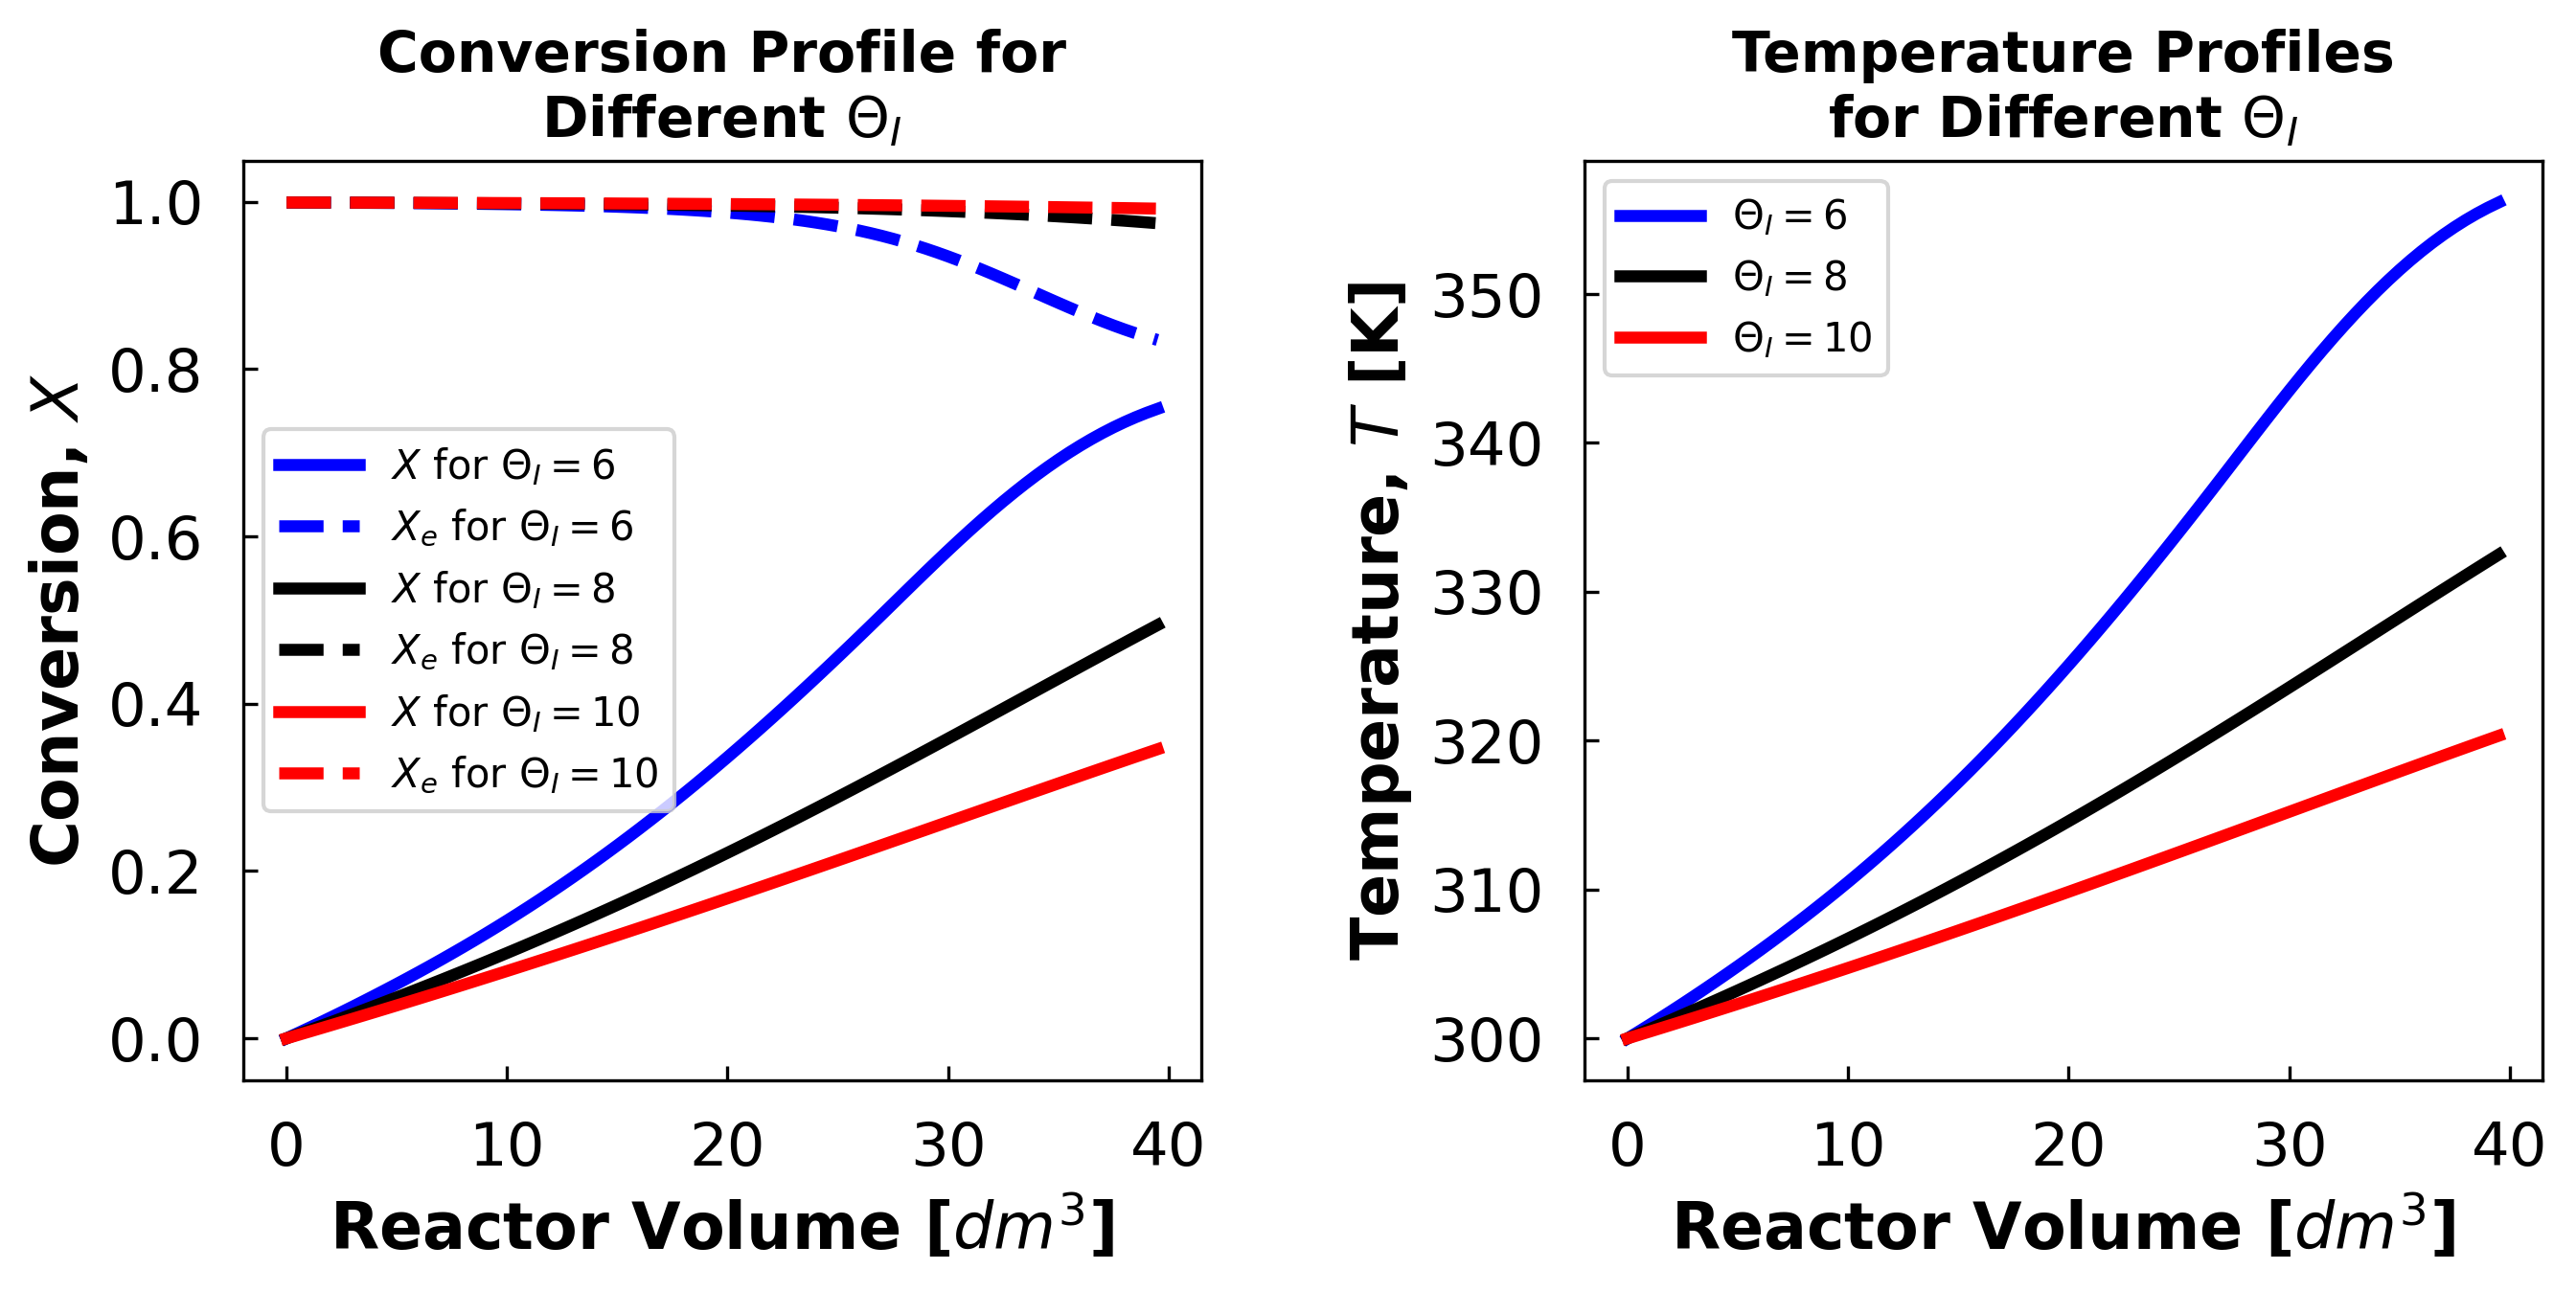

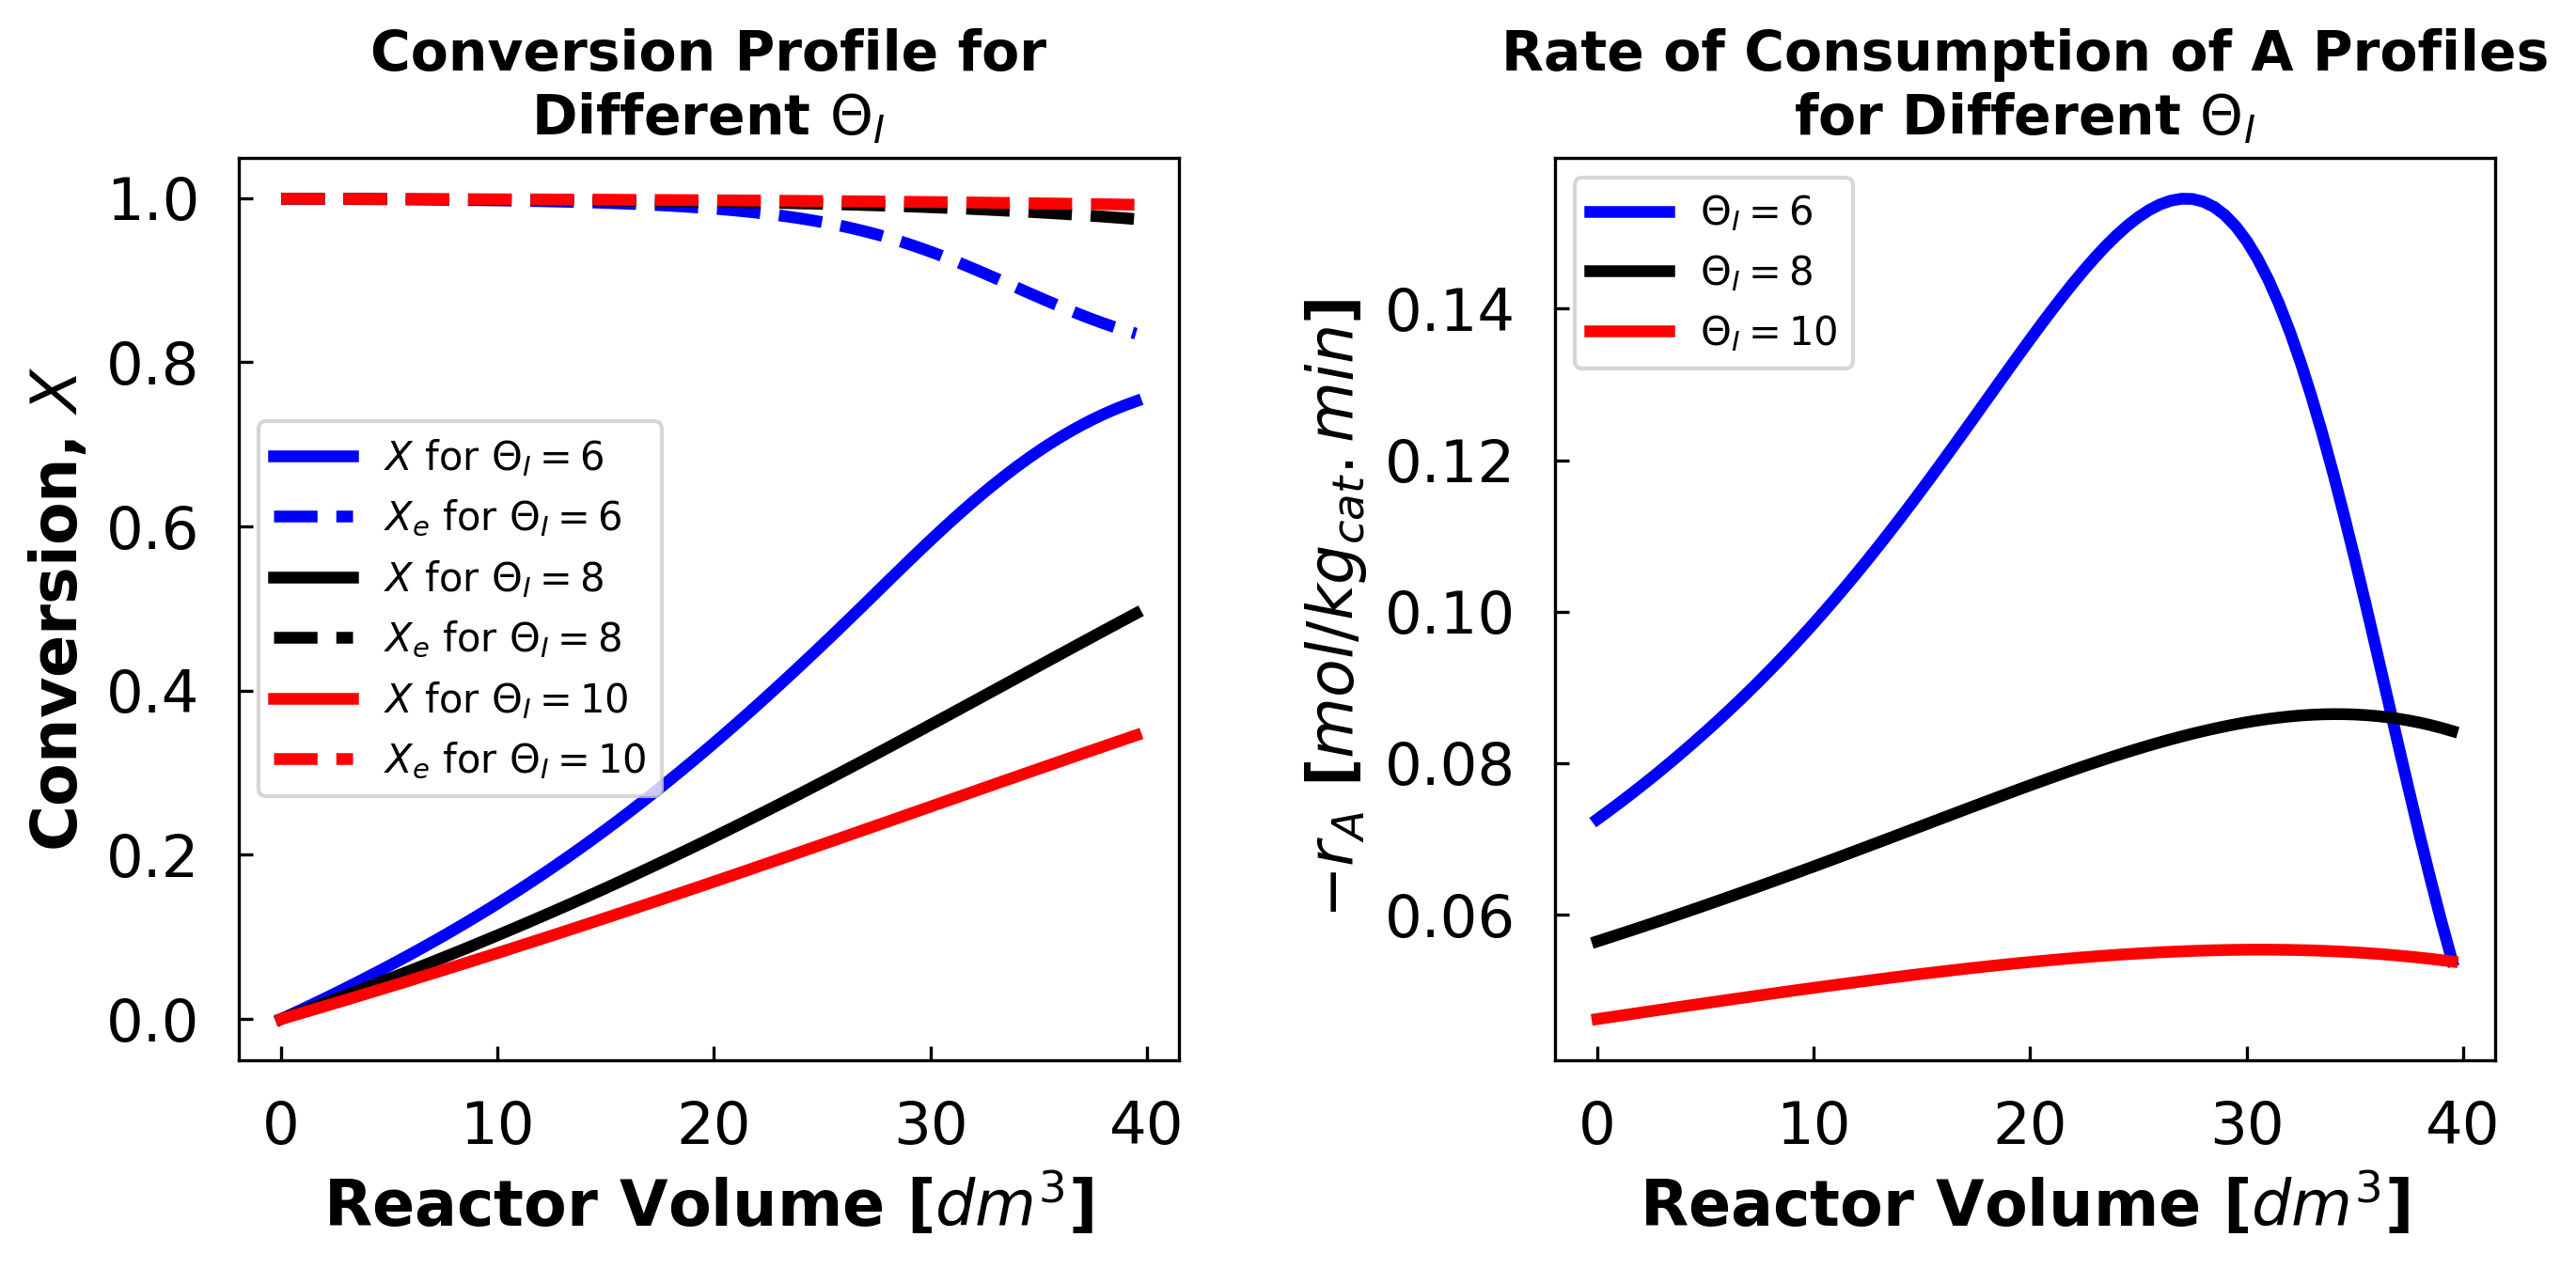

In [13]:
### BEGIN SOLUTION 
# List of thetas we are examining
theta0_list = [6, 8, 10]

# Creating a list of labels for plot labels
labels = [
    r"$\Theta_I = 6$",
    r"$\Theta_I = 8$",
    r"$\Theta_I = 10$"
]

# Parameters: [T0, theta_I, alpha, C_pA, C_pB, C_pI]
# Plot temperature profiles for different Θ_I values
plot_profiles('$\Theta_I$', 1, theta0_list, 'Temperature', labels, LOUD=False)

# Plot rate profiles for different Θ_I values
plot_profiles('$\Theta_I$', 1, theta0_list, 'Rate', labels, LOUD=False)
### END SOLUTIONS

**Discussion on High Theta Plots**:

In the high $\Theta_I$ plots, we notice a notable absence of equilibrium attainment, indicated by the failure of X and Xe to converge, and the expected pattern of a peak followed by a drop to equilibrium rate is absent in the rate of consumption plot. This observation implies that at elevated $\Theta_I$ values, the excessive presence of inert species overwhelms the reactive components, stifling the reaction to the extent that equilibrium remains unattainable.

## 4b. Effect of $T_0$

Solve for a set of cases where the inlet temperature varies $T_0=[280,350]$ K

 i) Solve for a set of Inlet Temperatures using solve_pbr. Hint: Use a for-loop just as in 4a


In [14]:
### BEGIN SOLUTION 
# Create a list of initial temperatures
T0_list_full = list(range(280, 350))

# Initialize an empty list to store exit conversions at different initial temperatures
X_for_temp_list = []

### BEGIN SOLUTION 
# Loop to solve using solve_pbr with different initial temperatures
for initial_temperature in T0_list_full:
    # Define the parameters
    params = [
        initial_temperature,  # Initial temperature [K]
        2,                    # Mol ratio of inert to reactive species
        0.02,                 # Alpha
        160,                  # Heat capacity of A [cal/mol.K]
        80,                   # Heat capacity of B [cal/mol.K]
        18,                   # Heat capacity of I [cal/mol.K]
    ]

    # Solve the reactor model
    V_range, X, Xe, rA, T, p = solve_pbr(params)

    # Append the exit conversions (last -X) to the list
    X_for_temp_list.append(-X[-1])
### END SOLUTIONS

 ii) Plot exit conversion $X_{out}$ vs $T_0$ and comment on the effect of inlet temperature. (1 sentence)

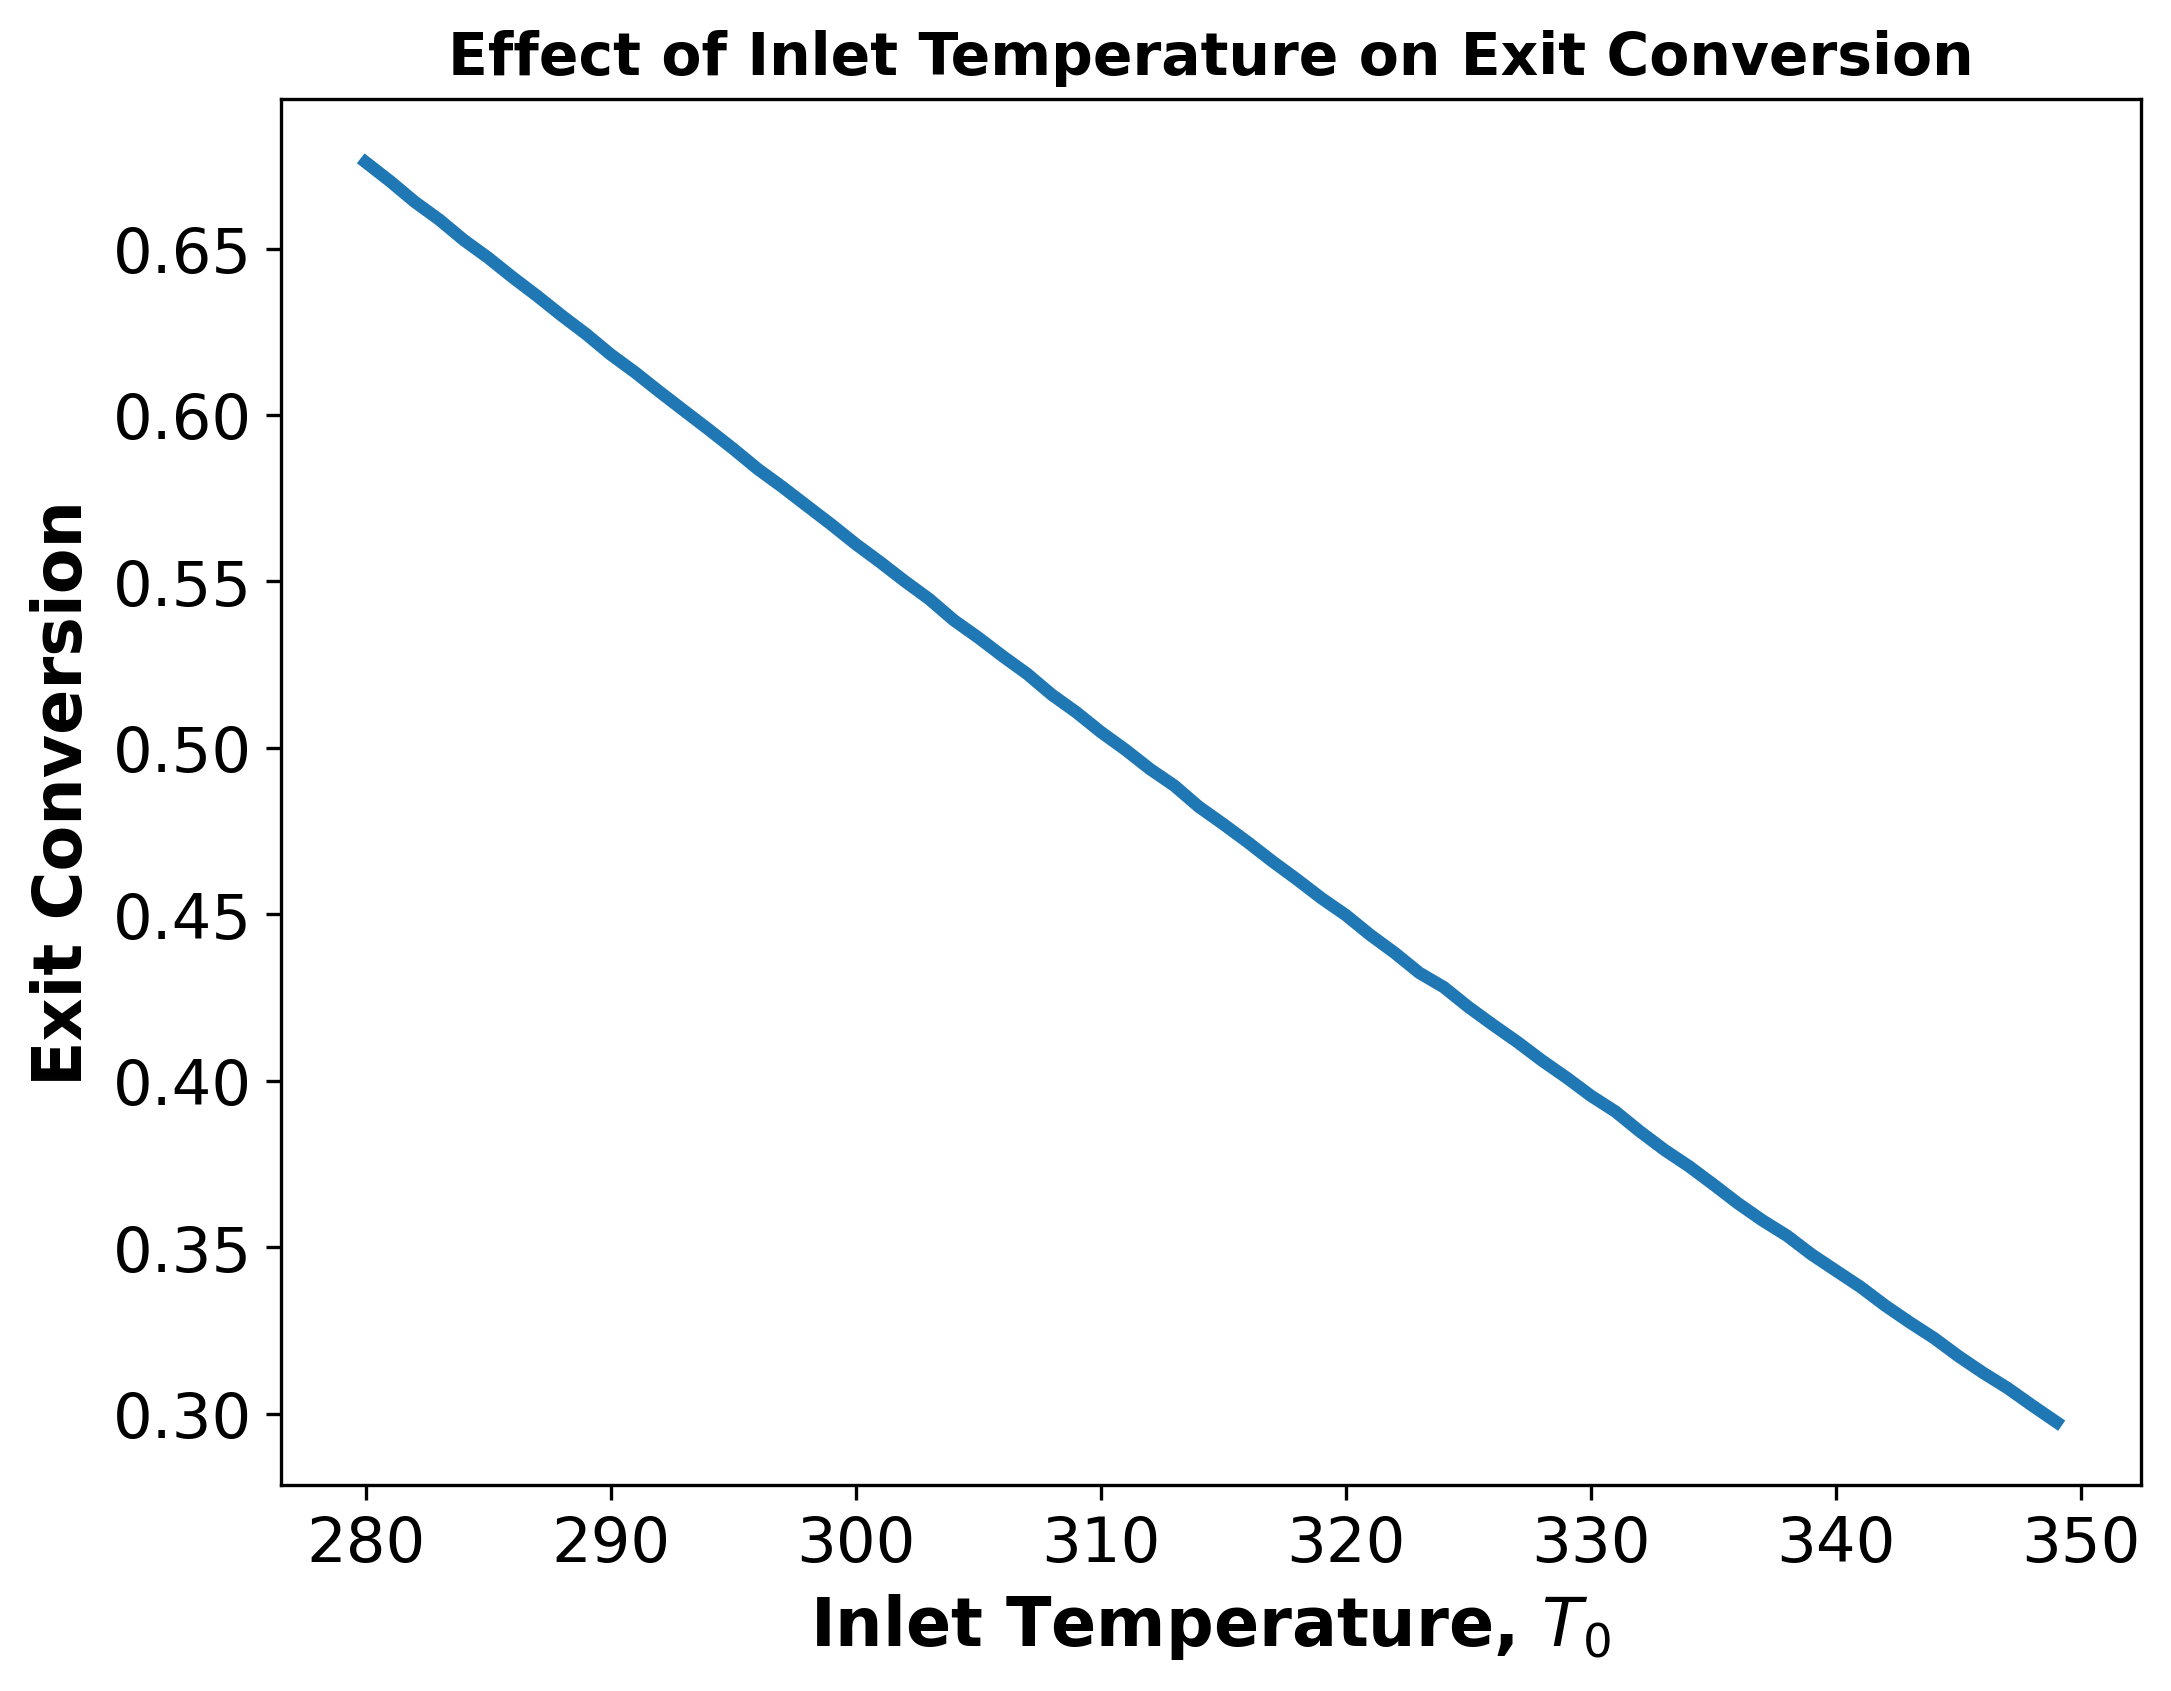

In [15]:
### BEGIN SOLUTION 
# Plot exit conversion vs initial temperature

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(T0_list_full, X_for_temp_list, linewidth=lin_wdth)

# Labels and title
plt.xlabel('Inlet Temperature, $T_0$', fontsize=16, fontweight='bold')
plt.ylabel('Exit Conversion', fontsize=16, fontweight='bold')
plt.title("Effect of Inlet Temperature on Exit Conversion", fontsize=14, fontweight='bold')

# Tick font sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Show the plot
plt.show()
### END SOLUTIONS

**Discussion**

Above we see that as the inlet temperature increases, the exit conversion decreases.

##### Examine the Influence of Initial Temperatures on Exit Conversion Trends:

By plotting conversion profiles (X and Xe) against reactor volume at various initial temperatures (280K, 300K, and 350K), along with temperature profiles (T) vs reactor volume, distinctive patterns emerge. 

Using the plots, discuss how initial temperature affects the equilibrium temperature and in turn the exit conversion. (2-3 sentences).

Answer: Higher initial temperatures lead to lower equilibrium temperatures, suggesting a more exothermic reaction. Consequently, the lower equilibrium temperatures result in higher exit conversions due to the favorable thermodynamics of the reaction at elevated temperatures. This analysis underscores the significant impact of initial temperature on both equilibrium conditions and the overall efficiency of the conversion process.

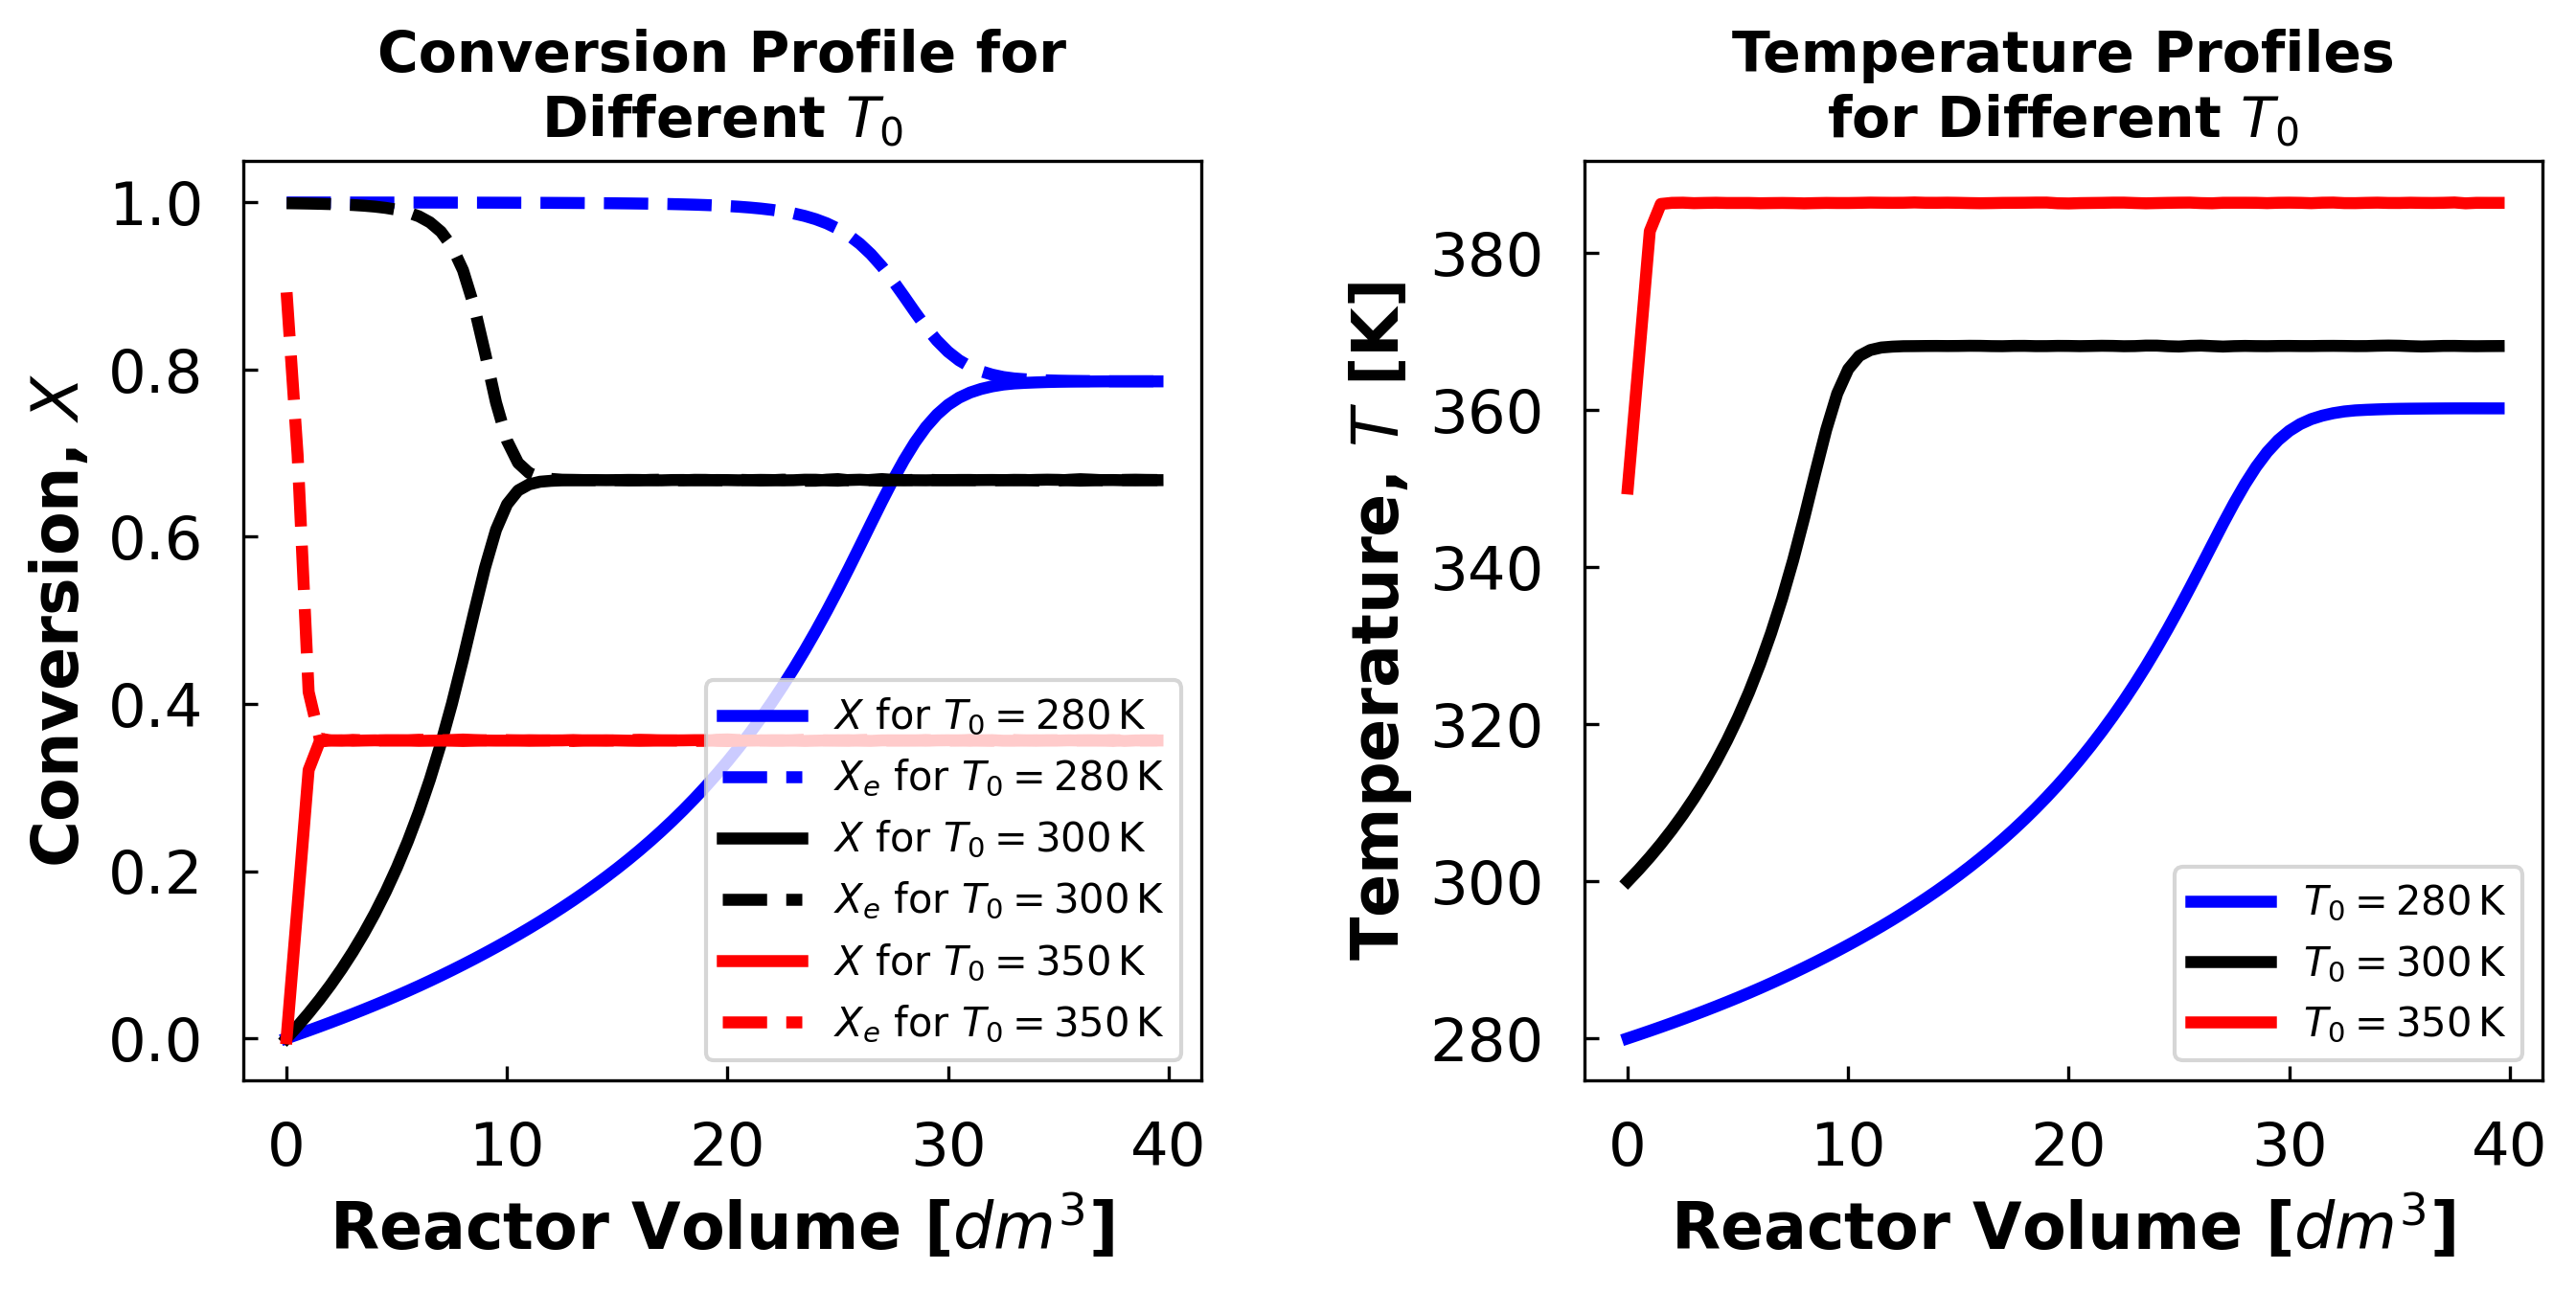

In [16]:
### BEGIN SOLUTION 
# Define labels and initial temperatures
labels = [
    r"$T_0 = 280 \, \mathrm{K}$",
    r"$T_0 = 300 \, \mathrm{K}$",
    r"$T_0 = 350 \, \mathrm{K}$",
]

T0_list = [280, 300, 350]

# Create temperature profiles using plot_profiles function
plot_profiles('$T_0$', 0, T0_list, 'Temperature', labels, LOUD=False)
### END SOLUTIONS

**Discussion:**

Above we see that as temperature increases, the temperature that equillibrium occurs at increases and the conversion decreases. This suggests that the reaction rate in inversly dependent on temperature with the reaction rate being faster when at lower temperatures.

## 4c. Optimal Temperature Control

Using the function `solve_pbr()`, find the optimal combination of $Θ_I$ and $T_0$ that maximizes $X_{out}$. Display in a contour plot. Comment on the optimization results and the trends in the contour plot (5-6 sentences).

Hint: Use a nested for-loop.

For information on making quality plots see:
https://ndcbe.github.io/data-and-computing/notebooks/01/Matplotlib.html

In [17]:
### BEGIN SOLUTION
import warnings
warnings.simplefilter('ignore')
 
# Create an empty array to store exit conversions for different initial thetas and temperatures
X_for_theta_and_temp = np.zeros((len(Theta0_list), len(T0_list_full)))

### BEGIN SOLUTION 
# Loop through both the initial thetas and the initial temperatures, solving using solve_pbr for each combination
for theta_index, theta_value in enumerate(Theta0_list):
    for temp_index, initial_temperature in enumerate(T0_list_full):
        # Define the parameters
        params = [
            initial_temperature,    # Initial temperature [K]
            theta_value,     # Mol ratio of inert to reactive species
            0.02,            # Alpha
            160,             # Heat capacity of A [cal/mol.K]
            160,             # Heat capacity of B [cal/mol.K]
            18,              # Heat capacity of I [cal/mol.K]
        ]
        V_range, X, Xe, rA, T, p = solve_pbr(params)

        # Store exit conversions in the array, indexed for the initial thetas and temperatures
        X_for_theta_and_temp[theta_index, temp_index] = -X[-1]
### END SOLUTIONS

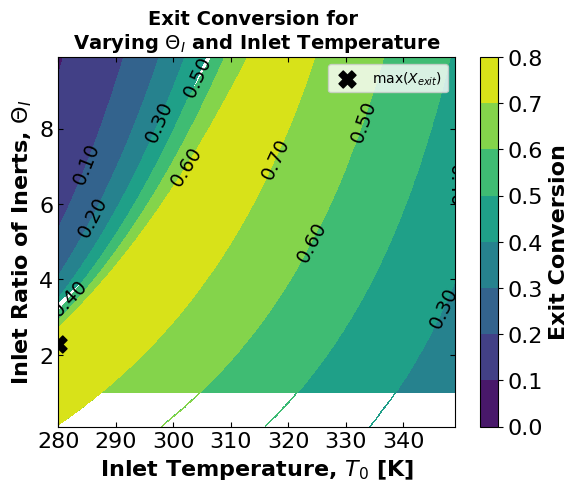

In [18]:
### BEGIN SOLUTION 
# Convert list of exit conversions for different theta_I and temp_I to an array
X_optim = np.array(X_for_theta_and_temp)

# Create a contour plot for X vs. T0 and Theta_I
cs = plt.contourf(
    T0_list_full, Theta0_list, X_optim,
    # levels=50,
)

# Add a color bar for the contour plot
cbar = plt.colorbar()

# Set the color bar title
cbar.ax.set_ylabel(r'Exit Conversion', fontsize=16, fontweight='bold')

# Set font size for the color bar
cbar.ax.tick_params(labelsize=16)

# Add contour labels with specific formatting
plt.clabel(cs, fmt='%2.2f', colors='k', fontsize=14)

# Set font sizes for x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set tick direction to 'in' for top and right sides
plt.tick_params(direction="in", top=True, right=True)

# Set plot title and axis labels
plt.xlabel('Inlet Temperature, $T_0$ [K]', fontsize=16, fontweight='bold')
plt.ylabel('Inlet Ratio of Inerts, $\Theta_I$', fontsize=16, fontweight='bold')
plt.title('Exit Conversion for \nVarying $\Theta_I$ and Inlet Temperature', fontsize=14, fontweight='bold')

# Adding points where X is maximized

# Find indices where X is maximized
ind_max = np.where(X_optim == X_optim.max())
X_maxima = X_optim[ind_max]

# Plot the maximum point
plt.scatter(
    T0_list_full[ind_max[1][0]],
    Theta0_list[ind_max[0][0]],
    label="max($X_{exit}$)",
    color='black',
    marker='X',
    s=150,
)

# Add a legend
plt.legend()

### END SOLUTIONS

In [19]:
### BEGIN SOLUTION 
# printing maximum exit conversion and optimal conditions for it
Xmax = X_optim[ind_max].copy()
Xmax.tolist()
print(
    "Maximum Exit Conversion: ",
      round(Xmax[0]*100, 2),"%",
    "\nOptimal Initial Temperature: ",
      T0_list_full[ind_max[1][0]], " K ",
      "\nOptimal Initial Theta: ",
      round(Theta0_list[ind_max[0][0]], 2)
      )
### END SOLUTIONS

Maximum Exit Conversion:  79.58 % 
Optimal Initial Temperature:  280  K  
Optimal Initial Theta:  2.3


##### Describe your Observation from the plot

1. Fill in
2. Fill in 
3. Fill in

**Discussion Answers**:

In our analysis, we aimed to determine the optimal initial conditions for achieving the highest exit conversion. The contour plot provides valuable insights into the interplay between initial temperature (T0) and initial theta (θ_I). 

The region in yellow represents the optimal conditions for maximizing exit conversion. Within this region, we find the maximum exit conversion is achieved with an initial temperature of 280 K and an initial theta of 2.3. 

However, the contour plot reveals a more nuanced relationship between initial conditions and exit conversion. For initial thetas between 0 and 2, low temperatures (around 280 K) are ideal. In contrast, for higher initial thetas (8-9), a higher temperature of around 310 K is preferable. The contour plot shows a smooth transition between these two extremes, indicating an optimal temperature range for intermediate initial thetas.

Contrary to our initial assumption that higher temperatures always lead to lower conversion, we observe that at high initial thetas, excessively low temperatures can also limit conversion. This counterintuitive result may be attributed to the fact that, at high initial thetas, the energy provided by higher temperatures is crucial for promoting interactions between reactive molecules, especially when they are in the minority compared to inert molecules. Therefore, there exists an optimal temperature range for high initial thetas, with both excessively high and low temperatures hindering conversion.

##### Discussion Question:
 What is the most influential parameter affecting exit conversion, and how does it impact the overall process efficiency?

The exit conversion is predominantly influenced by temperature, with higher temperatures resulting in decreased conversion. 